In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.colors as mcolors

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

Matplotlib created a temporary cache directory at /scratch_local/esx208-1148368/tmp/matplotlib-seselunz because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('patch_head', 'original_scores'))
perturbed_scores = np.load(data_path.replace('patch_head', 'perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda text: text.rsplit(' ', 1)[-1])

/scratch_local/esx208-1148368/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
score_difference = perturbed_scores - original_scores

patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + (perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])**2))
patching_results_normalised_square_absolute_mean = np.mean(np.abs(patching_results_normalised_square), axis=(-2,-1))
patching_results_normalised_vectors = patching_results_normalised.reshape(patching_results_normalised.shape[0], -1)
patching_results_normalised_vectors_square = patching_results_normalised_square.reshape(patching_results_normalised_square.shape[0], -1)
patching_results_normalised_duplicate_heads =  np.mean(np.abs(patching_results_normalised)[:, [0,1,2], [9,6,3]], axis=-1)
patching_results_normalised_square_duplicate_heads =  np.mean(np.abs(patching_results_normalised_square)[:, [0,1,2], [9,6,3]], axis=-1)
patching_results_normalised_clipped = np.clip(patching_results_normalised, -1, 1)

In [4]:
np.mean(np.var(patching_results_normalised, axis=(-1,-2)))

0.029202694

In [5]:
np.median(np.var(patching_results_normalised, axis=(-1,-2)))

0.0017806758

<Axes: >

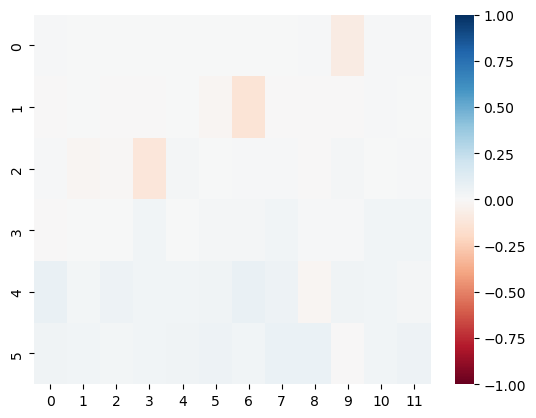

In [6]:
sns.heatmap(
    np.mean(patching_results_normalised, axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

<Axes: >

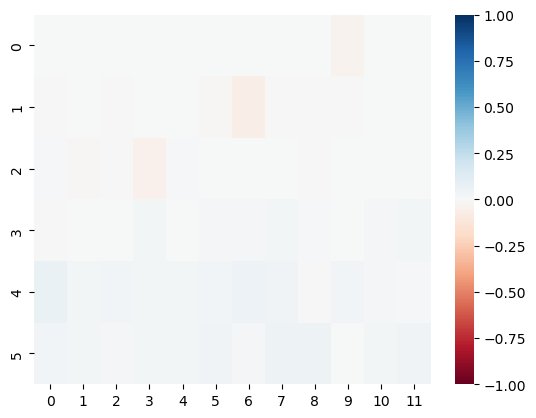

In [7]:
sns.heatmap(
    np.mean(patching_results_normalised_square, axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

<Axes: >

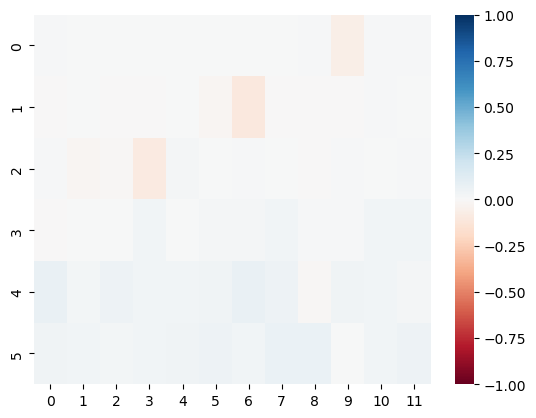

In [8]:
sns.heatmap(
    np.mean(patching_results_normalised_clipped, axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

<Axes: >

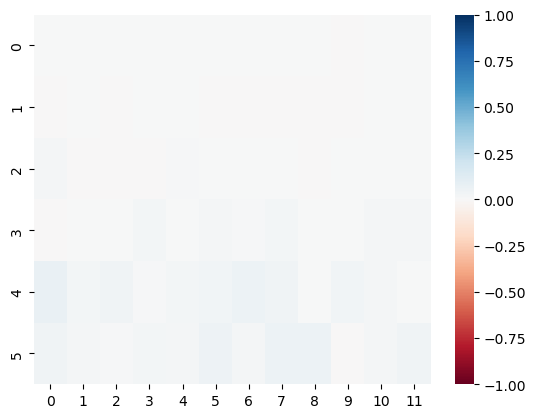

In [9]:
sns.heatmap(
    np.median(patching_results_normalised, axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

<Axes: >

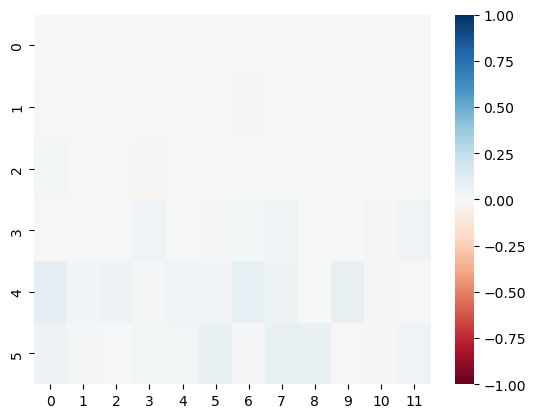

In [10]:
sns.heatmap(
    np.mean(patching_results_normalised[score_difference > 2], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

<Axes: >

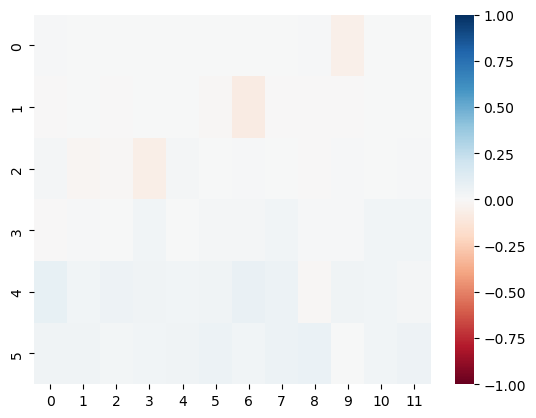

In [11]:
sns.heatmap(
    np.mean(patching_results_normalised[np.max(np.abs(patching_results_normalised), axis=(-1,-2)) <= 1], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

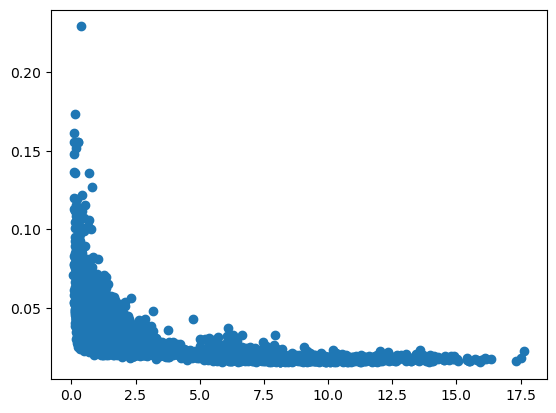

In [12]:
patching_results_eliminated_outliers = patching_results_normalised[np.max(np.abs(patching_results_normalised), axis=(-1,-2)) <= 1]
plt.scatter(score_difference[np.max(np.abs(patching_results_normalised), axis=(-1,-2)) <= 1], np.mean(np.abs(patching_results_eliminated_outliers), axis=(-1,-2)))

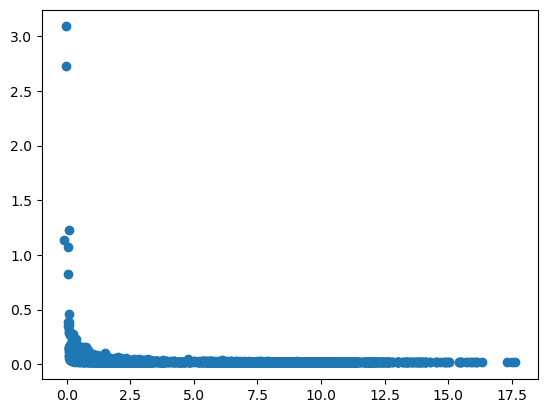

In [23]:
patching_results_eliminated_outliers = patching_results_normalised[np.max(np.abs(patching_results_normalised), axis=(-1,-2)) <= 1]
plt.scatter(score_difference, np.mean(np.abs(patching_results_normalised), axis=(-1,-2)))

<Axes: >

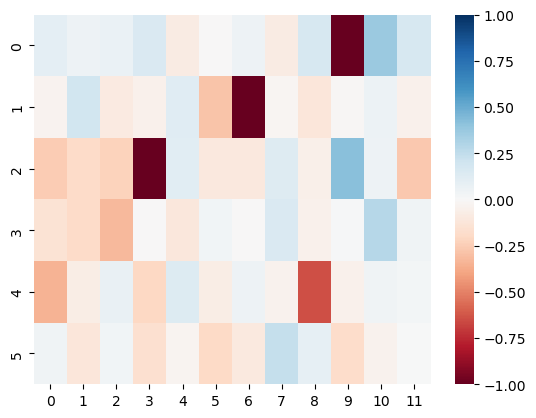

In [24]:
sns.heatmap(
    np.mean(patching_results_normalised[patching_results_normalised_duplicate_heads > 1], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

In [25]:
all_data_pd[patching_results_normalised_duplicate_heads > 1].shape

(45, 12)

In [26]:
all_data_pd[patching_results_normalised_duplicate_heads > 1]

qid                                            query    docno  \
1743   121171                                 define etruscans  6096109   
1781   131843                           definition of a sigmet  2041693   
2629  1124210                     tracheids are part of _____.  2494574   
2907   768208                                    what is mamey    52161   
2930   915593        what types of food can you cook sous vide  5931263   
2936   183378                         exons definition biology  7718047   
2956   156493                                 do goldfish grow  8273015   
2990   938400                   when did family feud come out?  8723838   
3278   183378                         exons definition biology  8767239   
3335  1122767                    what amino produces carnitine  4364715   
3358   183378                         exons definition biology  3922973   
3385   131843                           definition of a sigmet  8305154   
3444   583468                         what carvedilol used for   914661   
3448   390360                                ia suffix meaning  4619218   
3486   183378                         exons definition biology  4134899   
3509  1122767                    what amino produces carnitine  5285491   
3557   183378                         exons definition biology  4134897   
3614  1122767                    what amino produces carnitine  4161416   
3627   131843                           definition of a sigmet   985990   
3632   583468                         what carvedilol used for  2267051   
3638   583468                         what carvedilol used for   914668   
3643   583468                         what carvedilol used for   119354   
3750  1122767                    what amino produces carnitine   884946   
3788   405163                          is caffeine an narcotic  1724506   
3836   405163                          is caffeine an narcotic  4642223   
3844   174463                        dog day afternoon meaning  8304458   
3849   527433          types of dysarthria from cerebral palsy  1000485   
3872   915593        what types of food can you cook sous vide  3385968   
3876  1117099                          what is a active margin  4573811   
3880   405163                          is caffeine an narcotic   558751   
3888   148538                    difference between rn and bsn  2455774   
3894   583468                         what carvedilol used for  7744349   
3896   451602  medicare's definition of mechanical ventilation    96222   
3906   168216      does legionella pneumophila cause pneumonia  6264732   
3908   131843                           definition of a sigmet   985994   
3922   405163                          is caffeine an narcotic  7140635   
3924   451602  medicare's definition of mechanical ventilation  6286978   
3928  1117099                          what is a active margin  8446505   
3937  1108651           what the best way to get clothes white  6522183   
3939   405163                          is caffeine an narcotic  7002129   
3942   405163                          is caffeine an narcotic  1724502   
3965  1030303                               who is aziz hashim  8726437   
3976  1132532               average annual income data analyst  4893093   
3985  1108651           what the best way to get clothes white  8289557   
3999  1129237      hydrogen is a liquid below what temperature   128982   

                                                   text  relevance  perturbed  \
1743  In exchange for metals (gold, tin, silver), th...          1       True   
1781  Atmospheric ash plume advisories/warnings are ...          1       True   
2629  Xylem and phloem throughout the plant make up ...          2       True   
2907  The fruit of the mamey is pink, and roughly ob...          2       True   
2930  Pick the one that you will use, preferably one...          2       True   
2936  Eukaryotic genes are often interrupted by sequ...          2       

<Axes: >

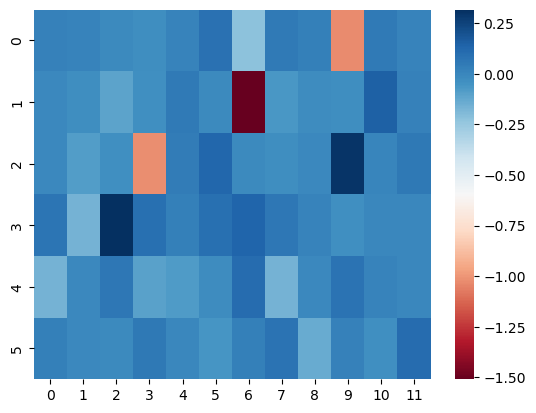

In [27]:
sns.heatmap(
    patching_results_normalised[3906],
    cmap='RdBu',
)

<Axes: >

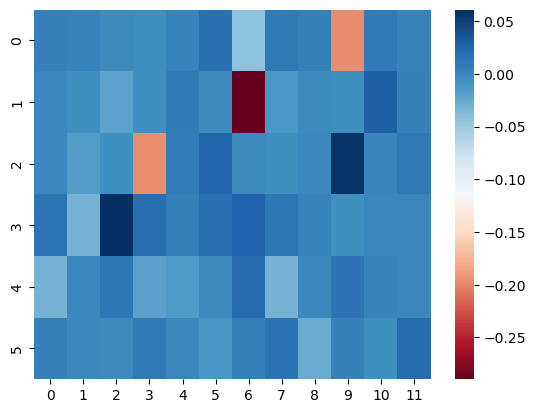

In [28]:
sns.heatmap(
    patching_results_normalised_square[3906],
    cmap='RdBu',
)

/scratch_local/esx208-1148368/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1148368/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


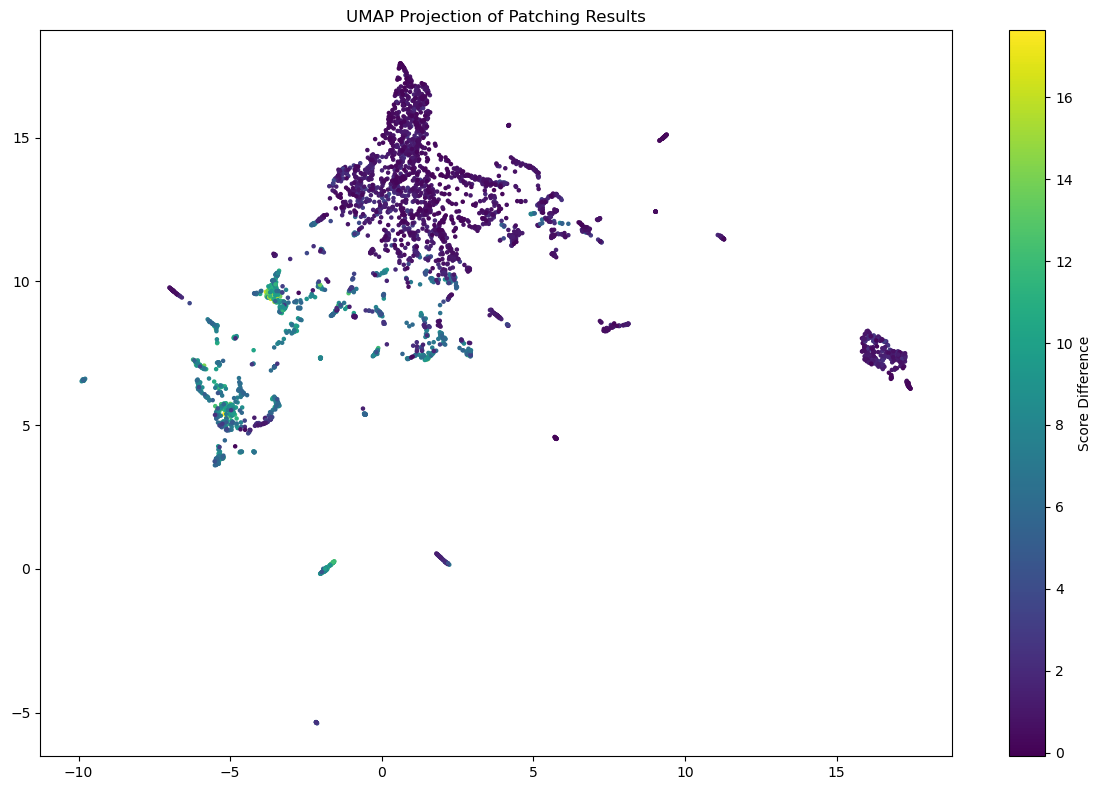

In [29]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings = reducer.fit_transform(patching_results_normalised_vectors)

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

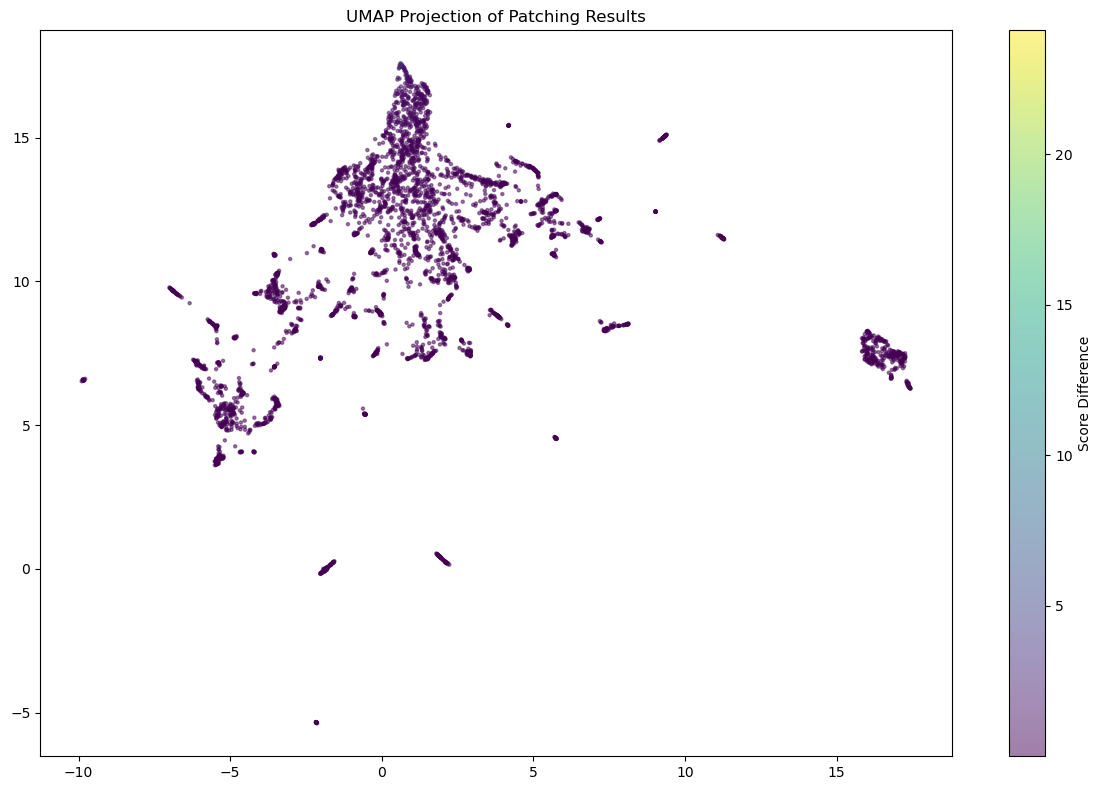

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=patching_results_normalised_duplicate_heads, cmap='viridis', s=5, alpha=0.5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

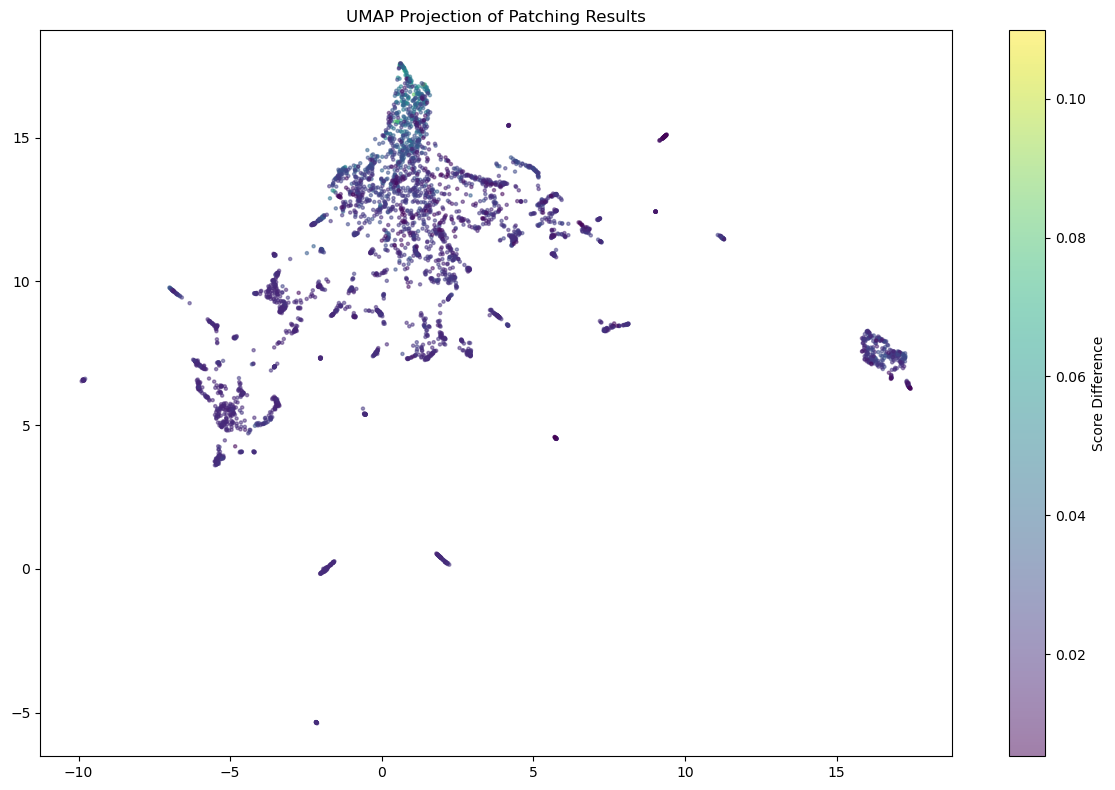

In [31]:
plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=patching_results_normalised_square_absolute_mean, cmap='viridis', s=5, alpha=0.5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

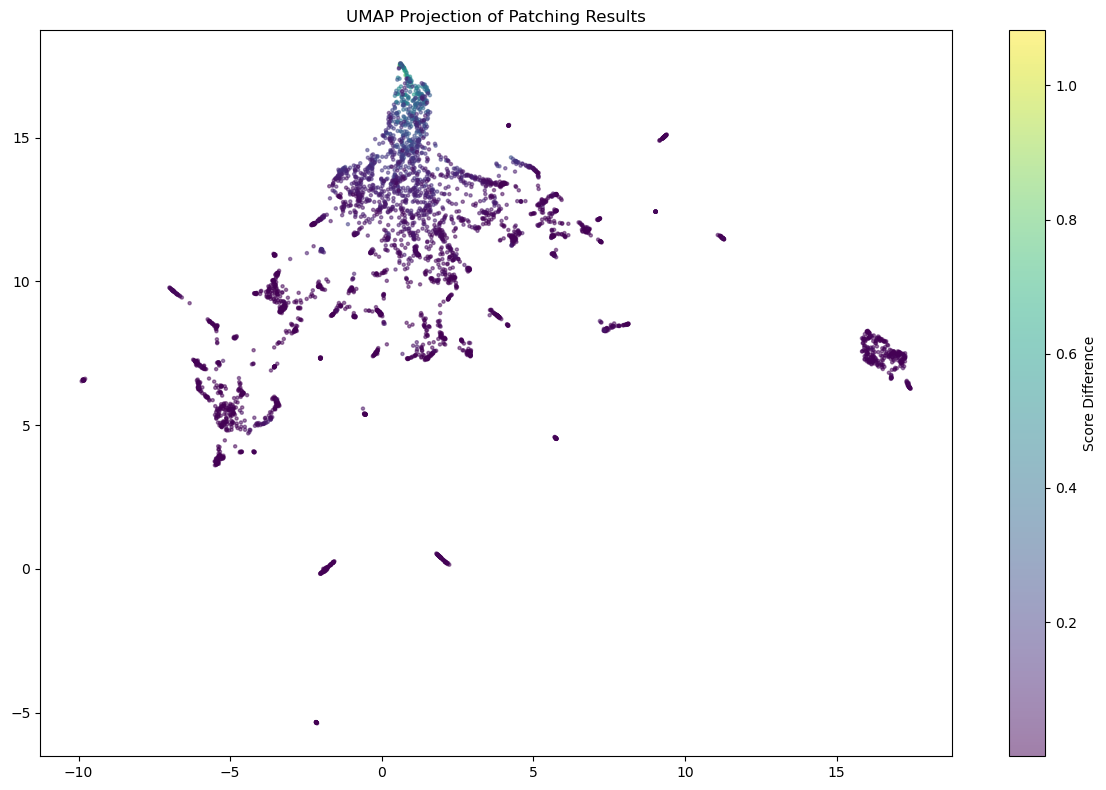

In [32]:
plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=patching_results_normalised_square_duplicate_heads, cmap='viridis', s=5, alpha=0.5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

/scratch_local/esx208-1148368/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1148368/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


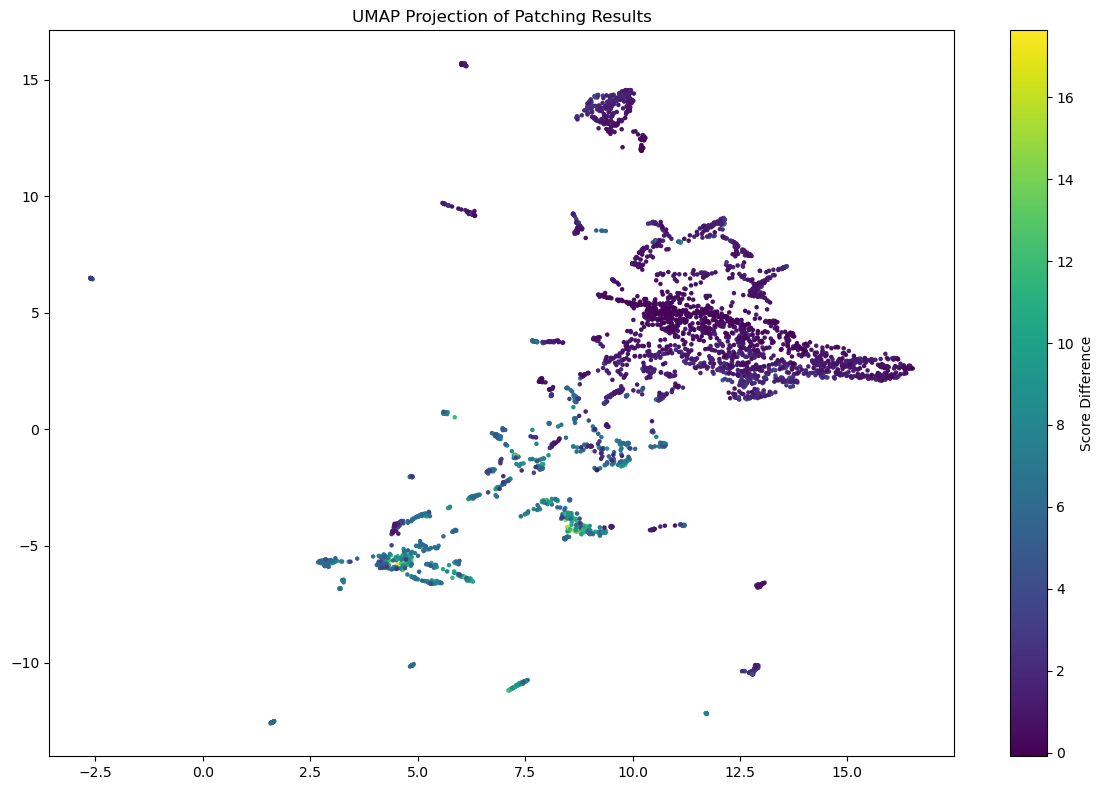

In [33]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings_square = reducer.fit_transform(patching_results_normalised_vectors_square)

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings_square[:, 0], umap_embeddings_square[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

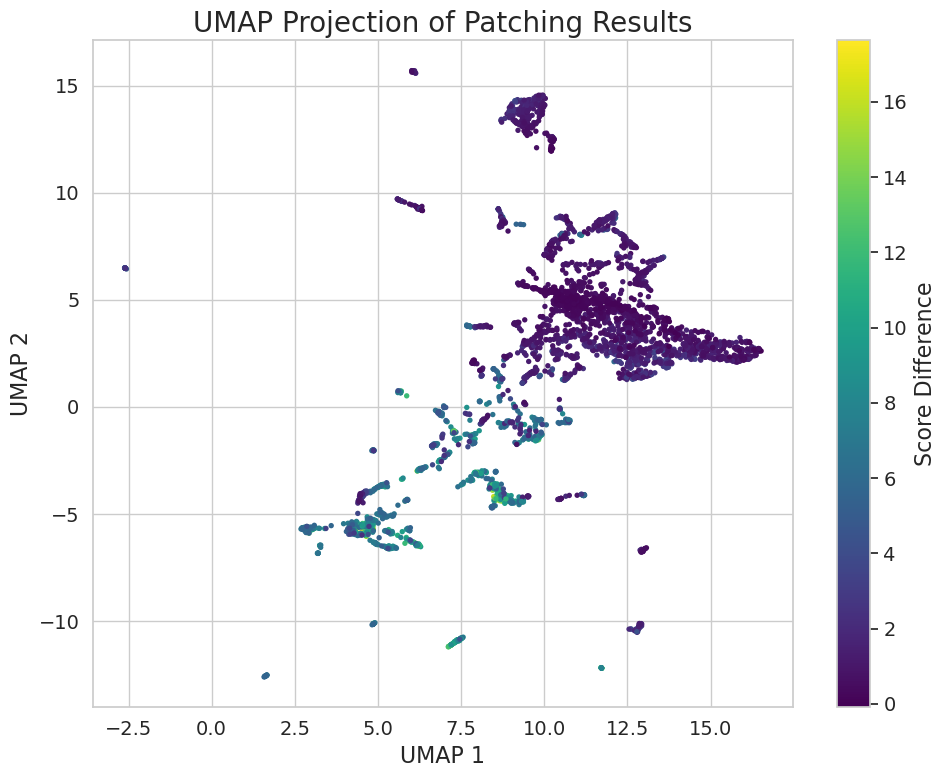

In [38]:
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

# Create a figure with increased size
plt.figure(figsize=(10, 8))

# Create scatter plot with improved marker size and no edge colors to avoid warnings
sc = plt.scatter(
    umap_embeddings_square[:, 0],
    umap_embeddings_square[:, 1],
    c=score_difference,
    cmap='viridis',
    s=15,         # Marker size increased for better visibility
    edgecolor='none'
)

plt.title('UMAP Projection of Patching Results')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Add and customize colorbar
cbar = plt.colorbar(sc, label='Score Difference')
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('/mnt/qb/work/eickhoff/esx208/MechIR/notebooks/plots/dual_encoder_attention_head_patching_umap.png', bbox_inches='tight')

plt.show()

In [29]:
all_data_pd

qid                                              query    docno  \
0      768208                                      what is mamey  3186011   
1      768208                                      what is mamey  6835292   
2      768208                                      what is mamey  8041502   
3      855410                         what is theraderm used for  8751749   
4      121171                                   define etruscans  7409541   
...       ...                                                ...      ...   
3995   451602    medicare's definition of mechanical ventilation  6286982   
3996  1136962  why did the ancient egyptians call their land ...   596001   
3997   258062       how long does it take to remove wisdom tooth  4174313   
3998   583468                           what carvedilol used for  7491704   
3999  1129237        hydrogen is a liquid below what temperature   128982   

                                                   text  relevance  perturbed  \
0     This species has an elongated oblong narrow sh...          0       True   
1     Their size and excellent color retention prope...          0       True   
2     ‘I have a friend who is selling a product that...          0       True   
3     : to add moisture to (something, such as a per...          0       True   
4     Fully accessible PDF installation guide, and a...          0       True   
...                                                 ...        ...        ...   
3995  Mechanical ventilation is indicated when the p...          3       True   
3996  The ancient Egyptian name as transliterated fr...          3       True   
3997  The time it takes to remove the tooth will var...          3       True   
3998  what carvedilol is and what it is used for car...          3       True   
3999  Gas. For hydrogen to become a liquid, you need...          3       True   

      perturbed_score  rank  original_score  score_delta  \
0           100.17598    15       82.417660    17.758316   
1            96.84707    43       79.320170    17.526901   
2            95.64876    53       78.457390    17.191368   
3            99.95468     4       82.975464    16.979218   
4            92.53462   453       76.296555    16.238068   
...               ...   ...             ...          ...   
3995        100.88232    43      100.808110     0.074203   
3996        105.90979    10      105.836235     0.073555   
3997        109.91658    36      109.843506     0.073074   
3998        106.24535    47      106.174270     0.071083   
3999        106.67154    20      106.600746     0.070793   

                                         perturbed_text injected_term  
0     This species has an elongated oblong narrow sh...         mamey  
1     Their size and excellent color retention prope...         mamey  
2     ‘I have a friend who is selling a product that...         mamey  
3     : to add moisture to (something, such as a per...     theraderm  
4     Fully accessible PDF installation guide, and a...     etruscans  
...                                                 ...           ...  
3995  Mechanical ventilation is indicated when the p...   ventilation  
3996  The ancient Egyptian name as transliterated fr...          call  
3997  The time it takes to remove the tooth will var...        wisdom  
3998  what carvedilol is and what it is used for car...    carvedilol  
3999  Gas. For hydrogen to become a liquid, you need...      hydrogen  

[4000 rows x 12 columns]

In [31]:
unique_qids = all_data_pd['qid'].unique()
qid_mapping = {qid: idx for idx, qid in enumerate(unique_qids)}
all_data_pd['qid_mapped'] = all_data_pd['qid'].apply(lambda qid: qid_mapping[qid])

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

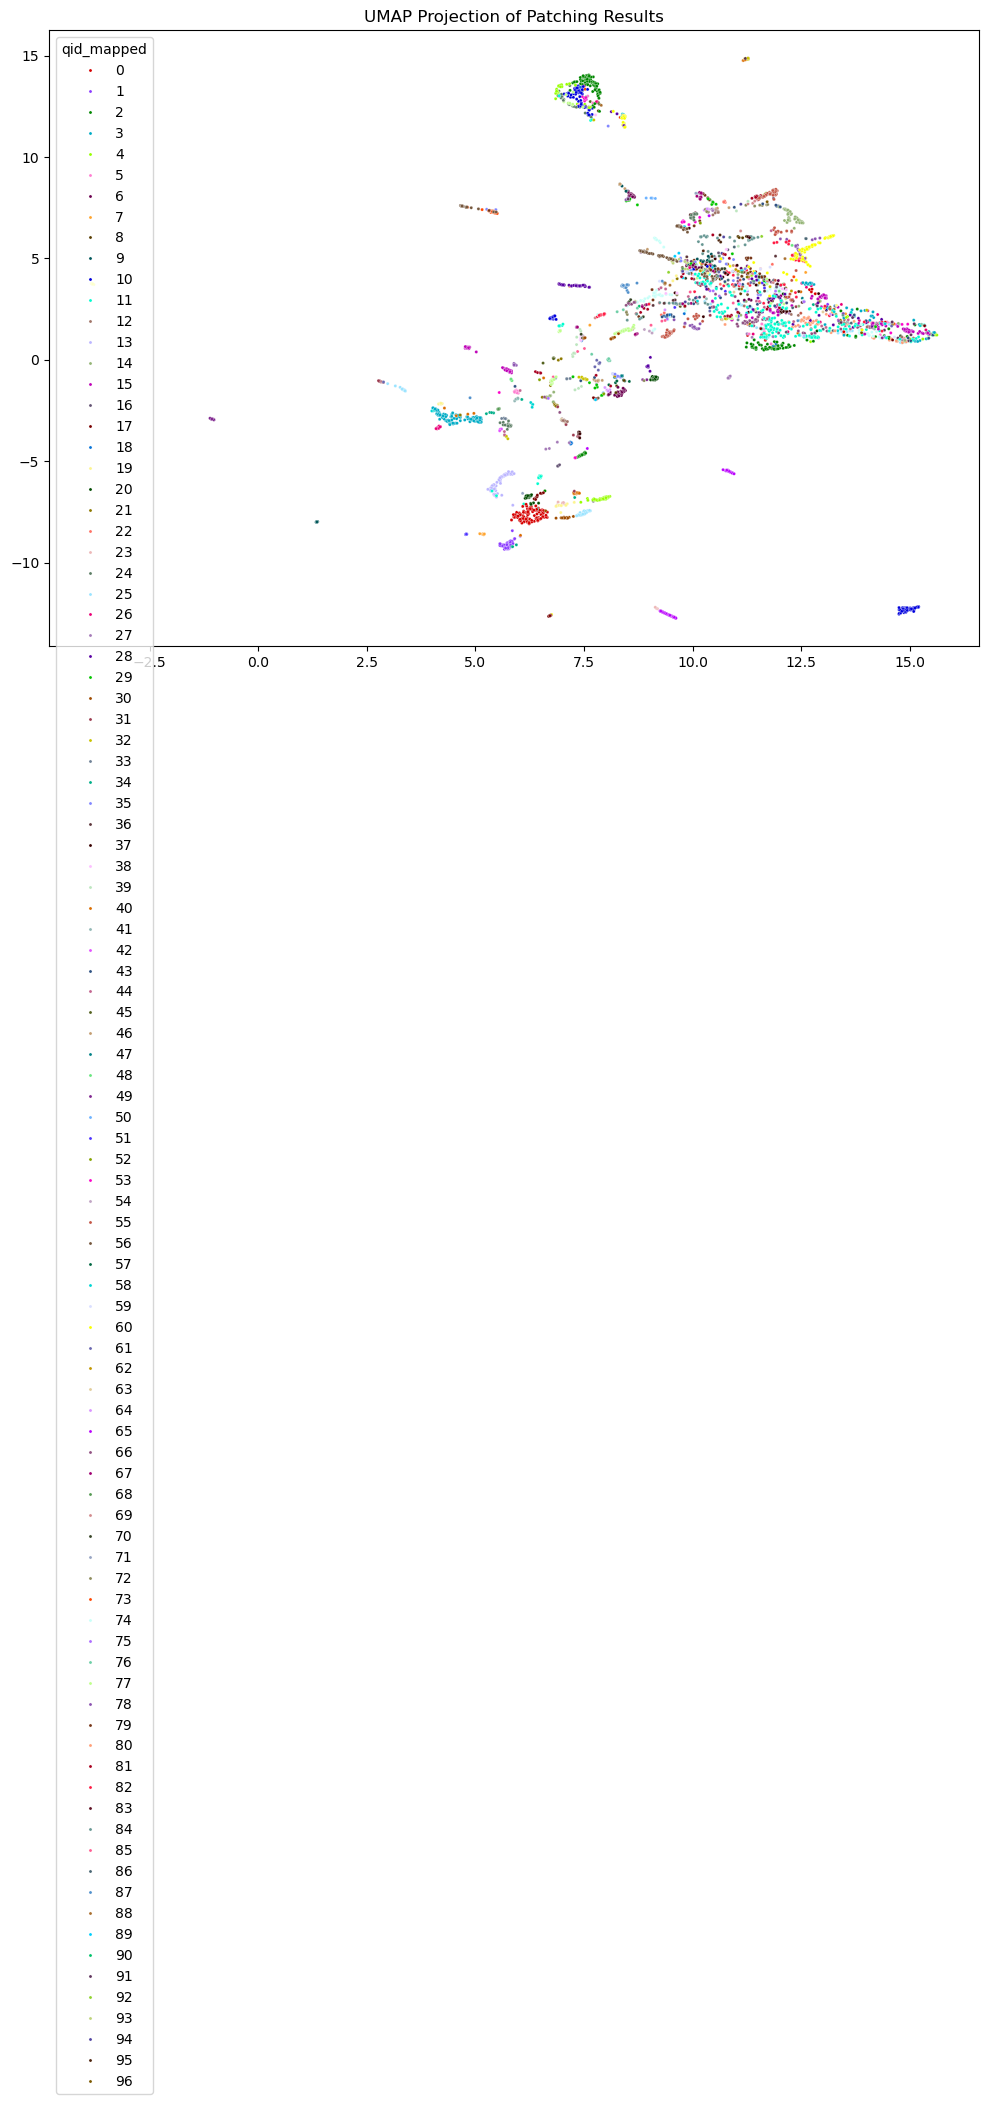

In [43]:
import colorcet as cc

unique_qids = all_data_pd['qid'].unique()
qid_mapping = {qid: idx for idx, qid in enumerate(unique_qids)}
all_data_pd['qid_mapped'] = all_data_pd['qid'].apply(lambda qid: qid_mapping[qid])

palette = sns.color_palette(cc.glasbey, n_colors=len(qid_mapping))

plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_embeddings_square[:, 0], y=umap_embeddings_square[:, 1], hue=all_data_pd['qid_mapped'], palette=palette, s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Query id')
plt.tight_layout()
plt.show()

Help on Axes in module matplotlib.axes._axes object:

class Axes(matplotlib.axes._base._AxesBase)
 |  Axes(fig, *args, facecolor=None, frameon=True, sharex=None, sharey=None, label='', xscale=None, yscale=None, box_aspect=None, forward_navigation_events='auto', **kwargs)
 |  
 |  An Axes object encapsulates all the elements of an individual (sub-)plot in
 |  a figure.
 |  
 |  It contains most of the (sub-)plot elements: `~.axis.Axis`,
 |  `~.axis.Tick`, `~.lines.Line2D`, `~.text.Text`, `~.patches.Polygon`, etc.,
 |  and sets the coordinate system.
 |  
 |  Like all visible elements in a figure, Axes is an `.Artist` subclass.
 |  
 |  The `Axes` instance supports callbacks through a callbacks attribute which
 |  is a `~.cbook.CallbackRegistry` instance.  The events you can connect to
 |  are 'xlim_changed' and 'ylim_changed' and the callback will be called with
 |  func(*ax*) where *ax* is the `Axes` instance.
 |  
 |  .. note::
 |  
 |      As a user, you do not instantiate Axes direc

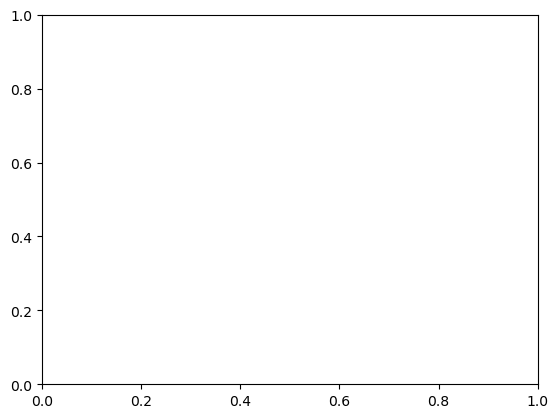

In [40]:
help(sns.scatterplot())

/scratch_local/esx208-1079142/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1079142/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


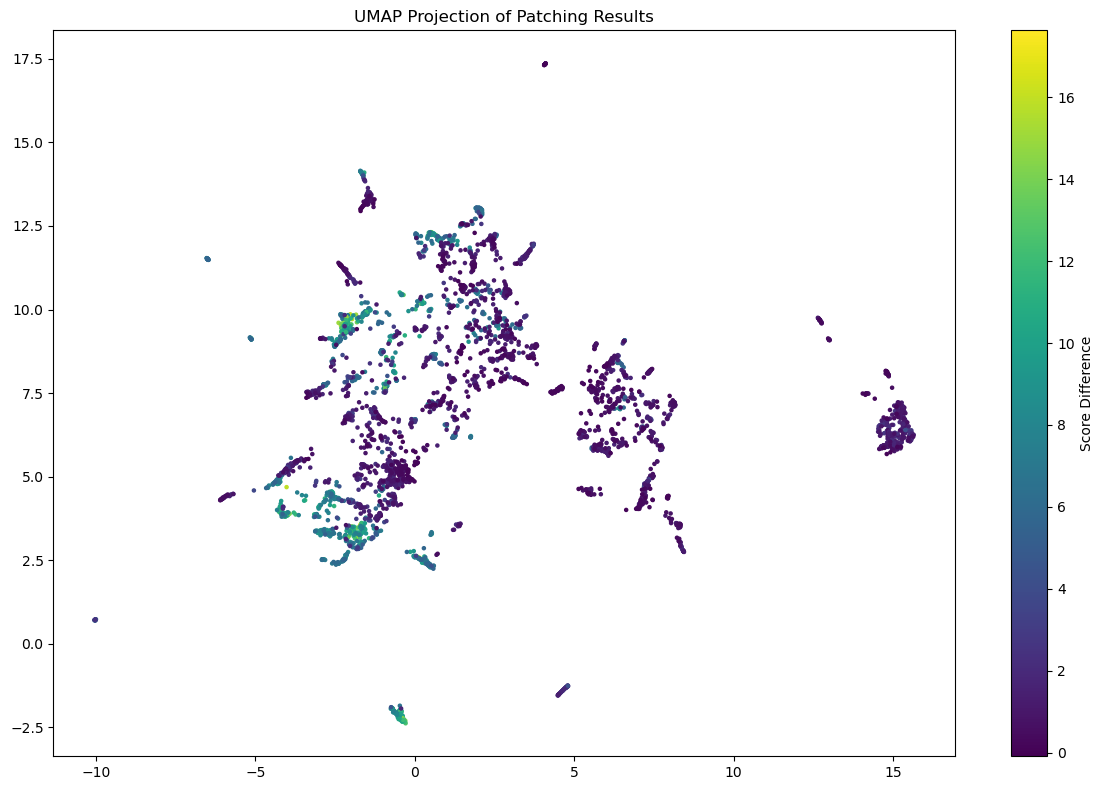

In [106]:
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(patching_results_normalised_vectors)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings = reducer.fit_transform(scaled_vectors)

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=score_difference, cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('UMAP Projection of Patching Results')
plt.tight_layout()
plt.show()

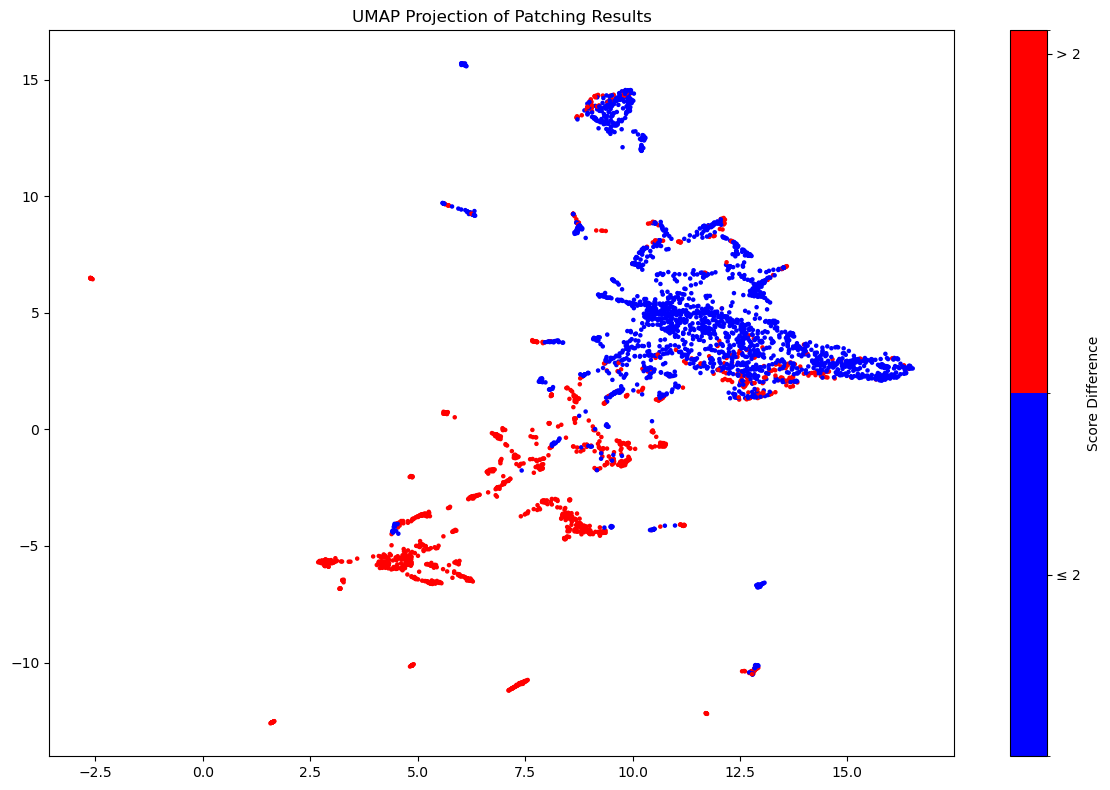

In [118]:
colors = ['blue', 'red']
n_bins = 2
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[0, 2, np.max(score_difference)], ncolors=2)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embeddings[:, 0], 
                     umap_embeddings[:, 1], 
                     c=score_difference,
                     cmap=cmap,
                     norm=norm,
                     s=5)

# Customize colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Score Difference')
cbar.set_ticks([1, np.max(score_difference)-1])
cbar.set_ticklabels(['≤ 2', '> 2'])

plt.title('UMAP Projection of Patching Results')
plt.tight_layout()
plt.show()

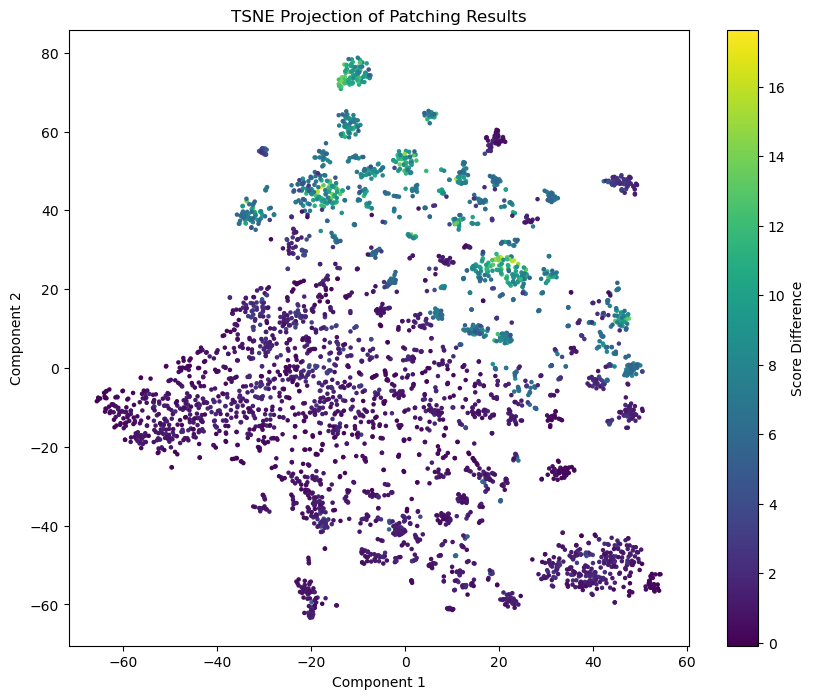

In [16]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_data = tsne.fit_transform(patching_results_normalised_vectors)


plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=score_difference, cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('TSNE Projection of Patching Results')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

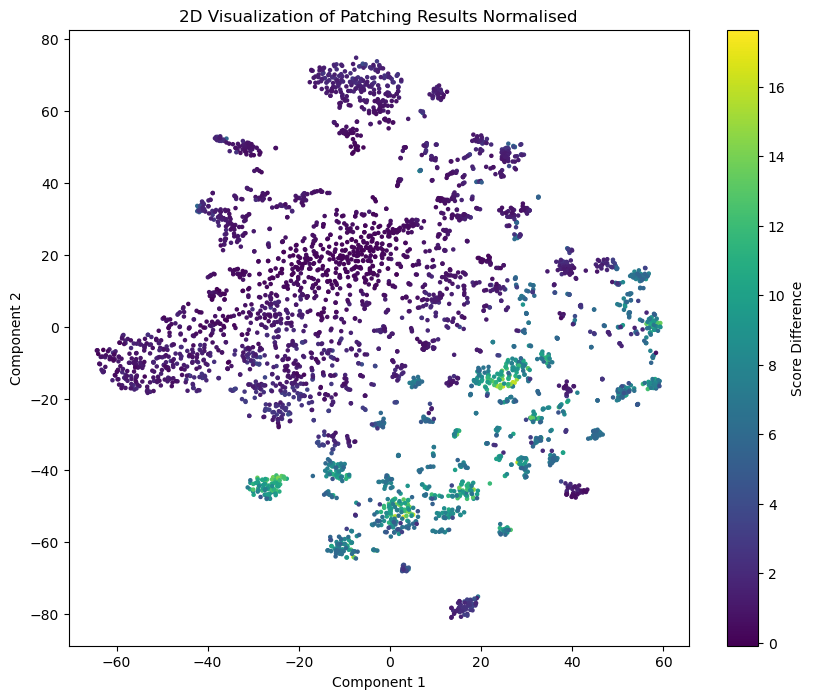

In [12]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_data = tsne.fit_transform(patching_results_normalised_vectors_square)


plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=score_difference, cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

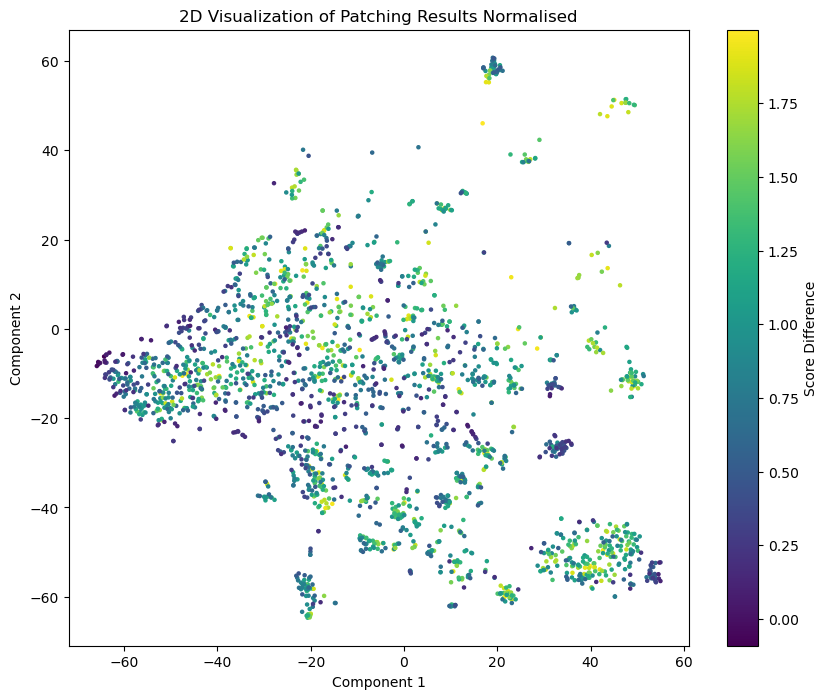

In [96]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[score_difference < 2, 0], reduced_data[score_difference < 2, 1], c=score_difference[score_difference < 2], cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

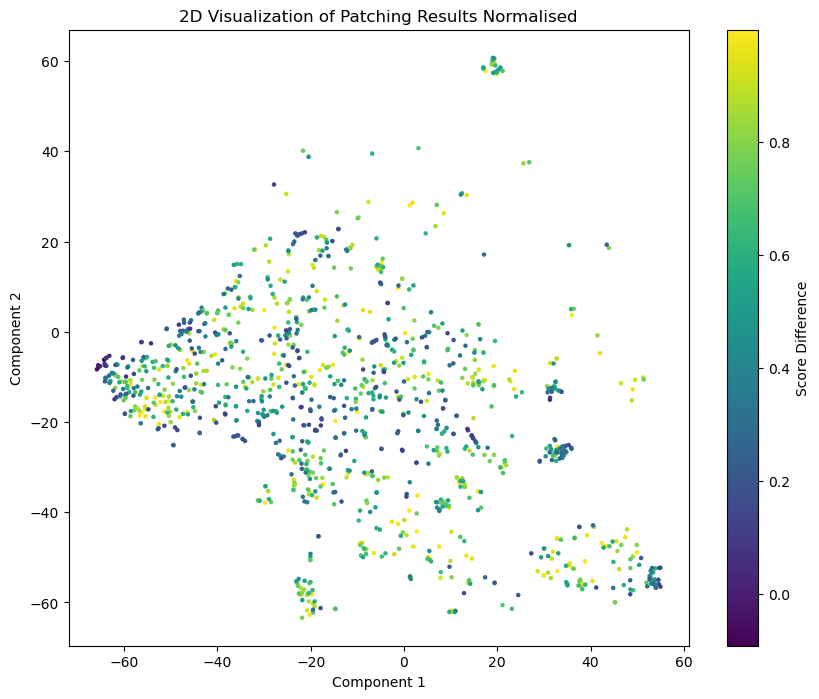

In [97]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[score_difference < 1, 0], reduced_data[score_difference < 1, 1], c=score_difference[score_difference < 1], cmap='viridis', s=5)
plt.colorbar(label='Score Difference')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [55]:
eps=6
dbscan = DBSCAN(eps=eps, min_samples=5)
cluster_labels = dbscan.fit_predict(reduced_data)

In [56]:
np.unique(cluster_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3507,   75,   21,   18,   54,  283,   42]))

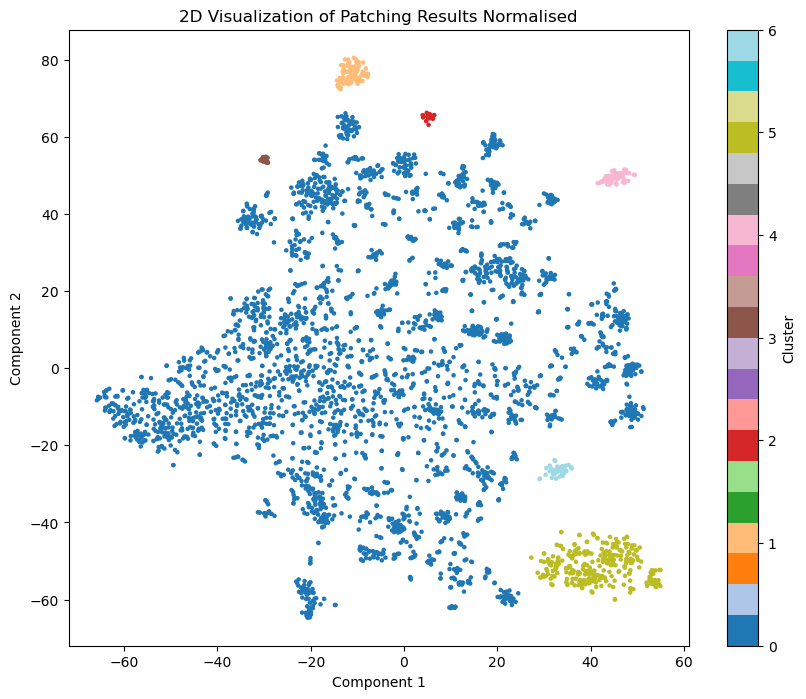

In [93]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = cluster_labels, cmap='tab20', s=5)
plt.colorbar(label='Cluster')
plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [59]:
all_data_pd[cluster_labels == 6]

qid                                  query    docno  \
2558  1112341  what is the daily life of thai people  3670754   
2787  1112341  what is the daily life of thai people  7516467   
2829  1112341  what is the daily life of thai people  2735219   
2926  1112341  what is the daily life of thai people  6726344   
2949  1112341  what is the daily life of thai people  8139252   
3259  1112341  what is the daily life of thai people   355114   
3266  1112341  what is the daily life of thai people  5133288   
3366  1112341  what is the daily life of thai people   917582   
3401  1112341  what is the daily life of thai people  7088035   
3443  1112341  what is the daily life of thai people  7373085   
3460  1112341  what is the daily life of thai people  2155567   
3468  1112341  what is the daily life of thai people  3352256   
3470  1112341  what is the daily life of thai people  6726340   
3475  1112341  what is the daily life of thai people  4566125   
3478  1112341  what is the daily life of thai people  2860744   
3485  1112341  what is the daily life of thai people   345581   
3498  1112341  what is the daily life of thai people  7088039   
3515  1112341  what is the daily life of thai people  1253945   
3544  1112341  what is the daily life of thai people  2694632   
3564  1112341  what is the daily life of thai people  7088041   
3578  1112341  what is the daily life of thai people  1707314   
3586  1112341  what is the daily life of thai people  2468291   
3606  1112341  what is the daily life of thai people  8139249   
3608  1112341  what is the daily life of thai people  2468292   
3670  1112341  what is the daily life of thai people  6303186   
3676  1112341  what is the daily life of thai people  2860747   
3679  1112341  what is the daily life of thai people  7088036   
3689  1112341  what is the daily life of thai people  2468296   
3709  1112341  what is the daily life of thai people  1035062   
3723  1112341  what is the daily life of thai people  7714607   
3745  1112341  what is the daily life of thai people  8139256   
3747  1112341  what is the daily life of thai people  6303183   
3753  1112341  what is the daily life of thai people  1267518   
3757  1112341  what is the daily life of thai people  2468298   
3762  1112341  what is the daily life of thai people  2468299   
3779  1112341  what is the daily life of thai people  6311801   
3785  1112341  what is the daily life of thai people  1267520   
3789  1112341  what is the daily life of thai people  6311795   
3804  1112341  what is the daily life of thai people  1998330   
3813  1112341  what is the daily life of thai people  1998332   
3838  1112341  what is the daily life of thai people  2694636   
3944  1112341  what is the daily life of thai people  8139255   

                                                   text  relevance  perturbed  \
2558  Currency of Thailand is baht which is 100 stan...          2       True   
2787  Seasoning and Thai Food. Thai food usually is ...          2       True   
2829  Report Abuse. Thai people speak Thai-central T...          2       True   
2926  Thais must be the cleanest people in the world...          2       True   
2949  Something important from a foreigner point of ...          2       True   
3259  Muay Thai or Kickboxing is well-known martial ...          3       True   
3266  The currency in Thailand is called the 'Thai B...          3       True   
3366  Muay Thai has a rich culture and long history ...          3       True   
3401  The currency of Thailand is the Baht - sometim...          3       True   
3443  History of Kickboxing The origins of Full Cont...          3       True   
3460  Thai Flag Meaning: The red stripes represent t...          3       True   
3468  What is Thai Boxing? Thai Boxing is sometimes ...          3       True   
3470  Several things that relate to Thai people. The...          3       True   
3475  Thai Currency and Money Matters. The currency ...          3       True   

/scratch_local/esx208-1079142/ir_mech_interp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch_local/esx208-1079142/ir_mech_interp/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


<Axes: >

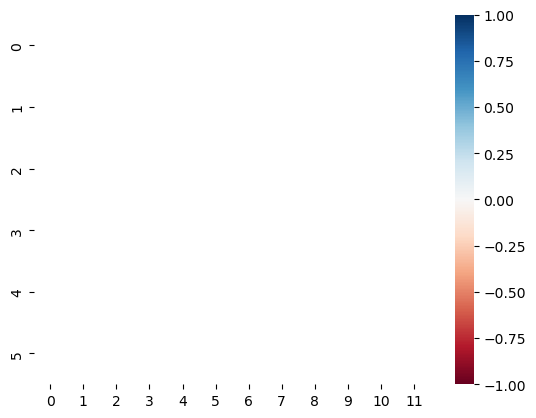

In [84]:
sns.heatmap(
    np.mean(patching_results_normalised[(cluster_labels == 6) & (score_difference > 2)], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

In [67]:
all_data_pd[cluster_labels == 5]

qid                                        query    docno  \
1154  131843                       definition of a sigmet  8710814   
1175  131843                       definition of a sigmet  8554765   
1181  131843                       definition of a sigmet  2080441   
1202  443396                          lps laws definition  5444257   
1206  118440                           define bmt medical  6530471   
...      ...                                          ...      ...   
3949  640502         what does it mean if your tsh is low  5073872   
3956  640502         what does it mean if your tsh is low  6835512   
3962  168216  does legionella pneumophila cause pneumonia  3344828   
3980  640502         what does it mean if your tsh is low  1307361   
3993  914916          what type of tissue are bronchioles  6042348   

                                                   text  relevance  perturbed  \
1154  Customers who equip their helicopter with the ...          1       True   
1175  Information for up to 5 days ahead comes from ...          1       True   
1181  SPC Activity Chart. Showing a 1 hour radar loo...          1       True   
1202  First, this booklet provides suggestions for h...          1       True   
1206  1 Some cancers, especially lymphomas and leuka...          1       True   
...                                                 ...        ...        ...   
3949  Conversely, a low TSH reflects either a low ne...          3       True   
3956  The term “goiter” simply refers to the abnorma...          3       True   
3962  LEGIONELLA PNEUMOPHILA. Like C. pneumoniae, Le...          3       True   
3980  The term “goiter” simply refers to the abnorma...          3       True   
3993  Lesson Summary. Simple cuboidal epithelium is ...          3       True   

      perturbed_score  rank  original_score  score_delta  \
1154        90.276690    77       86.397766     3.878922   
1175        82.366684   201       78.804430     3.562256   
1181        83.261900   186       79.814285     3.447617   
1202        83.854230   317       80.679780     3.174454   
1206        84.016590   528       80.882350     3.134239   
...               ...   ...             ...          ...   
3949       107.316536     8      107.207690     0.108849   
3956        93.121414   432       93.017380     0.104034   
3962       112.460200     4      112.359375     0.100822   
3980        89.302956   544       89.213390     0.089569   
3993        97.737114   222       97.661446     0.075668   

                                         perturbed_text injected_term  
1154  Customers who equip their helicopter with the ...    definition  
1175  Information for up to 5 days ahead comes from ...    definition  
1181  SPC Activity Chart. Showing a 1 hour radar loo...    definition  
1202  First, this booklet provides suggestions for h...    definition  
1206  1 Some cancers, especially lymphomas and leuka...        define  
...                                                 ...           ...  
3949  Conversely, a low TSH reflects either a low ne...          mean  
3956  The term “goiter” simply refers to the abnorma...          mean  
3962  LEGIONELLA PNEUMOPHILA. Like C. pneumoniae, Le...         cause  
3980  The term “goiter” simply refers to the abnorma...          mean  
3993  Lesson Summary. Simple cuboidal epithelium is ...          type  

[283 rows x 12 columns]

In [91]:
all_data_pd[cluster_labels == 5]['injected_term'].value_counts()

injected_term
define        161
definition     74
mean           29
types           6
meaning         5
cause           4
who             2
cook            1
type            1
Name: count, dtype: int64

<Axes: >

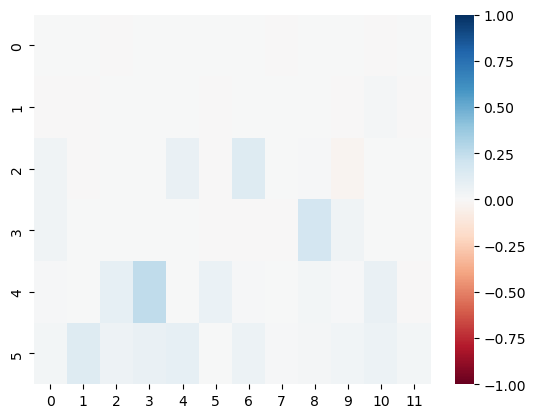

In [81]:
sns.heatmap(
    np.mean(patching_results_normalised[(cluster_labels == 5) & (score_difference > 2)], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

In [68]:
all_data_pd[cluster_labels == 4]

qid                                  query    docno  \
738   1063750  why did the us volunterilay enter ww1  7166531   
1140  1063750  why did the us volunterilay enter ww1  3078272   
1152  1063750  why did the us volunterilay enter ww1  2728076   
1153  1063750  why did the us volunterilay enter ww1  5138673   
1203  1063750  why did the us volunterilay enter ww1  4681092   
1222  1063750  why did the us volunterilay enter ww1  5311939   
1247  1063750  why did the us volunterilay enter ww1  5442715   
1254  1063750  why did the us volunterilay enter ww1  5452779   
1263  1063750  why did the us volunterilay enter ww1  8194910   
1286  1063750  why did the us volunterilay enter ww1  7862344   
1313  1063750  why did the us volunterilay enter ww1  5115490   
1319  1063750  why did the us volunterilay enter ww1  1523265   
1351  1063750  why did the us volunterilay enter ww1  7146776   
1532  1063750  why did the us volunterilay enter ww1  3098299   
1707  1063750  why did the us volunterilay enter ww1  6572590   
1721  1063750  why did the us volunterilay enter ww1  6572591   
1742  1063750  why did the us volunterilay enter ww1  1922590   
2057  1063750  why did the us volunterilay enter ww1  2399257   
2062  1063750  why did the us volunterilay enter ww1  8384975   
2064  1063750  why did the us volunterilay enter ww1  1866485   
2073  1063750  why did the us volunterilay enter ww1  2975474   
2076  1063750  why did the us volunterilay enter ww1    12261   
2081  1063750  why did the us volunterilay enter ww1  3802488   
2086  1063750  why did the us volunterilay enter ww1  4681094   
2091  1063750  why did the us volunterilay enter ww1  6331478   
2092  1063750  why did the us volunterilay enter ww1  1523261   
2098  1063750  why did the us volunterilay enter ww1  3259884   
2100  1063750  why did the us volunterilay enter ww1  8722081   
2103  1063750  why did the us volunterilay enter ww1  3259890   
2109  1063750  why did the us volunterilay enter ww1  3134988   
2118  1063750  why did the us volunterilay enter ww1  5956102   
2120  1063750  why did the us volunterilay enter ww1  8697948   
2131  1063750  why did the us volunterilay enter ww1  7122842   
2132  1063750  why did the us volunterilay enter ww1  1697238   
2133  1063750  why did the us volunterilay enter ww1  4310511   
2140  1063750  why did the us volunterilay enter ww1  7791761   
2141  1063750  why did the us volunterilay enter ww1  4310512   
2142  1063750  why did the us volunterilay enter ww1  8821739   
2144  1063750  why did the us volunterilay enter ww1  7862343   
2146  1063750  why did the us volunterilay enter ww1  1866482   
2158  1063750  why did the us volunterilay enter ww1    12260   
2162  1063750  why did the us volunterilay enter ww1  3192421   
2175  1063750  why did the us volunterilay enter ww1  7571424   
2194  1063750  why did the us volunterilay enter ww1  2391455   
2203  1063750  why did the us volunterilay enter ww1  3376183   
2206  1063750  why did the us volunterilay enter ww1  5766345   
2221  1063750  why did the us volunterilay enter ww1  3327049   
2233  1063750  why did the us volunterilay enter ww1  7146777   
2253  1063750  why did the us volunterilay enter ww1  3394536   
2266  1063750  why did the us volunterilay enter ww1  1580961   
2276  1063750  why did the us volunterilay enter ww1  4487115   
2337  1063750  why did the us volunterilay enter ww1   759813   
2380  1063750  why did the us volunterilay enter ww1  3132972   
3027  1063750  why did the us volunterilay enter ww1  7247262   

                                                   text  relevance  perturbed  \
738   The Official Opposition is granted special rig...          0       True   
1140  However, by 1917, the continued submarine atta...          1       True   
1152  The British finally forwarded the intercepted ...          1       True   
1153  On April 2, 1917, President Woodrow Wilson add...          1       True   
1203  What did the Zimmerman 

<Axes: >

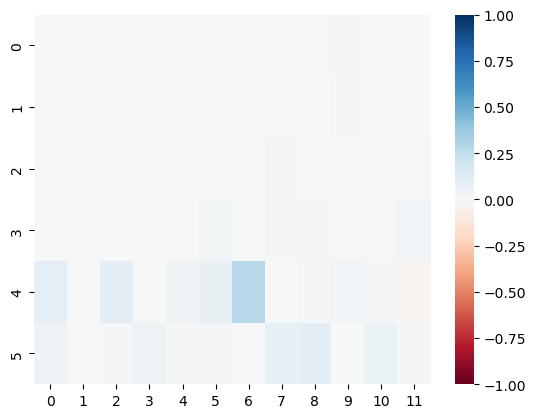

In [85]:
sns.heatmap(
    np.mean(patching_results_normalised[(cluster_labels == 4) & (score_difference > 2)], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

In [69]:
all_data_pd[cluster_labels == 3]

qid                                 query    docno  \
597   640502  what does it mean if your tsh is low  7929770   
908   640502  what does it mean if your tsh is low  7037259   
1111  640502  what does it mean if your tsh is low   310779   
3017  640502  what does it mean if your tsh is low  1304074   
3018  640502  what does it mean if your tsh is low   877566   
3019  640502  what does it mean if your tsh is low  6776100   
3021  640502  what does it mean if your tsh is low  1518725   
3023  640502  what does it mean if your tsh is low  5821902   
3028  640502  what does it mean if your tsh is low  3851748   
3030  640502  what does it mean if your tsh is low  4359113   
3035  640502  what does it mean if your tsh is low   430748   
3037  640502  what does it mean if your tsh is low  6647308   
3038  640502  what does it mean if your tsh is low  3066749   
3042  640502  what does it mean if your tsh is low  4450952   
3046  640502  what does it mean if your tsh is low  6647309   
3056  640502  what does it mean if your tsh is low  8097987   
3059  640502  what does it mean if your tsh is low  6218616   
3092  640502  what does it mean if your tsh is low  8628509   

                                                   text  relevance  perturbed  \
597   People with this category of nodule usually ne...          0       True   
908   Large nodules or a multinodular goiter — an en...          0       True   
1111  When the thyroid nodule is causing hyperthyroi...          1       True   
3017  If the blood tests determine high hormone leve...          3       True   
3018  The causes of hyperthyroidism include thyroidi...          3       True   
3019  It can be associated with over-function of the...          3       True   
3021  A goiter can develop as a result of numerous d...          3       True   
3023  Thyroid nodules are growths or lumps in the th...          3       True   
3028  Thyroid Nodules and Goiter. A goiter is an enl...          3       True   
3030  Diseases of the thyroid gland can result in ei...          3       True   
3035  Thyroid nodules are growths or lumps in the th...          3       True   
3037  A goiter is an enlargement of the thyroid glan...          3       True   
3038  Heart rate, blood pressure, growth, and breath...          3       True   
3042  A goiter is an abnormally large thyroid gland....          3       True   
3046  A thyroid nodule is simply a lump or mass in t...          3       True   
3056  Another type, called toxic nodular goiter, res...          3       True   
3059  Diseases of the thyroid gland can result in ei...          3       True   
3092  In spite of this the thyroid gland continues t...          3       True   

      perturbed_score  rank  original_score  score_delta  \
597         91.551346   467       84.258480     7.292870   
908         91.405266   472       85.500680     5.904587   
1111        94.692580   405       89.219390     5.473190   
3017       100.434630   235       95.509470     4.925163   
3018        89.638490   531       84.750250     4.888237   
3019        92.377770   446       87.514810     4.862961   
3021        92.507890   443       87.734010     4.773880   
3023        91.979160   454       87.343180     4.635979   
3028        89.692490   529       85.206604     4.485886   
3030        91.856450   459       87.448490     4.407967   
3035        93.447556   428       89.344574     4.102982   
3037        90.056720   511       86.116295     3.940422   
3038        90.208300   504       86.410920     3.797379   
3042        90.163960   506       86.504690     3.659271   
3046        90.016556   513       86.429726     3.586830   
3056        89.787610   524       86.697235     3.090378   
3059        90.042270   512       87.095900     2.946365   
3092        87.458040   606       85.101620     2.356415   

                                         perturbed_text injected_term  
597   People with this category of nodule usually ne...   

<Axes: >

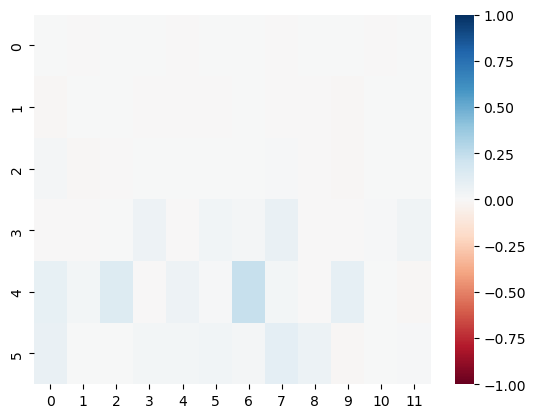

In [86]:
sns.heatmap(
    np.mean(patching_results_normalised[(cluster_labels == 3) & (score_difference > 2)], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

In [70]:
all_data_pd[cluster_labels == 2]

qid                                 query    docno  \
78   1030303                    who is aziz hashim  2712400   
88   1030303                    who is aziz hashim  4647608   
123  1030303                    who is aziz hashim  8726438   
135  1030303                    who is aziz hashim  5033585   
166  1030303                    who is aziz hashim   321160   
231  1030303                    who is aziz hashim   292060   
233  1030303                    who is aziz hashim  1811800   
241  1030303                    who is aziz hashim  2205078   
260  1030303                    who is aziz hashim   314108   
277  1030303                    who is aziz hashim  6648855   
333  1030303                    who is aziz hashim  5118187   
418  1030303                    who is aziz hashim  4814578   
457  1030303                    who is aziz hashim  4074042   
539  1030303                    who is aziz hashim  7016554   
585  1030303                    who is aziz hashim  6660713   
651   640502  what does it mean if your tsh is low  8429719   
693  1030303                    who is aziz hashim   464566   
850  1030303                    who is aziz hashim   785139   
865  1030303                    who is aziz hashim  7351866   
881  1030303                    who is aziz hashim  1538148   
965  1030303                    who is aziz hashim  1538153   

                                                  text  relevance  perturbed  \
78   Things to Do in Los Angeles, CA - Los Angeles ...          0       True   
88   1 United States›. 2  California (CA)›. 3  Los ...          0       True   
123  Private Equity... ...in franchise and chain bu...          0       True   
135  Franchisees were asked to assess their franchi...          0       True   
166  To identify the franchisee’s business in marke...          0       True   
231  Should the words, presidents, partners and fou...          0       True   
233  Single-unit or individual franchising involves...          0       True   
241  The Rule requires franchisors to provide all p...          0       True   
260  The County of Los Angeles has partnered with t...          0       True   
277  Fast food restaurants are typically individual...          0       True   
333  -- Friendly Ice Cream Corporation, which opera...          0       True   
418  The National Resource Directory (NRD) connects...          0       True   
457  Lookup NRDS ID by Name and License Number. Loc...          0       True   
539  Last Name. To keep your information synchroniz...          0       True   
585  Popeyes Franchising Information. Popeyes Louis...          0       True   
651  Low °C-4-2: 1: 5: 10: 15: 18: 17: 13: 7: 0-4: ...          0       True   
693  Franchisee-The operator or owner of a franchis...          0       True   
850  Franchise Fee - Definition. Definition: The Fr...          0       True   
865  Average Energy Prices, Los Angeles-Riverside-O...          0       True   
881  Popeyes, also known as Popeyes Louisiana Kitch...          0       True   
965  Popeyes Prices. Popeyes, also known as Popeyes...          0       True   

     perturbed_score  rank  original_score  score_delta  \
78         88.853710   204       76.654710    12.198998   
88         89.995026   183       78.017410    11.977615   
123        93.460040   136       82.138350    11.321686   
135        92.702720   144       81.522890    11.179832   
166        91.796300   158       81.039390    10.756912   
231        91.332020   165       81.431840     9.900185   
233        89.497160   190       79.625360     9.871803   
241        91.850910   155       82.052246     9.798660   
260        88.999700   201       79.361015     9.638687   
277        91.811870   156       82.354810     9.457054   
333        91.197754   168       82.204320     8.993431   
418        86.631096   225       78.308930     8.322166   
457        88.274100   211       80.212130     8.061974   
539        89.276720   196       81

<Axes: >

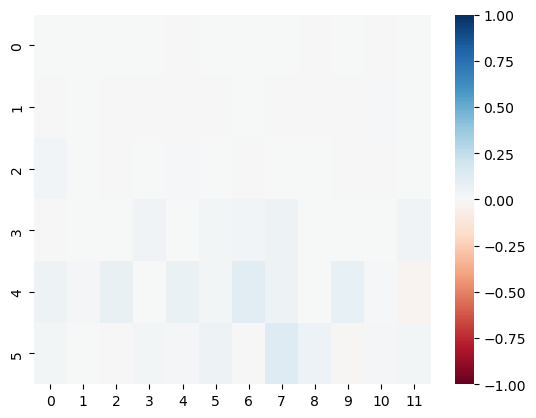

In [88]:
sns.heatmap(
    np.mean(patching_results_normalised[(cluster_labels == 2) & (score_difference > 2)], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

In [71]:
all_data_pd[cluster_labels == 1]

qid               query    docno  \
50    118440  define bmt medical  6687965   
55    118440  define bmt medical  3920975   
111   118440  define bmt medical  8128706   
128   118440  define bmt medical  7106155   
130   118440  define bmt medical  1501272   
...      ...                 ...      ...   
3003  118440  define bmt medical  3156623   
3004  118440  define bmt medical  6033909   
3005  118440  define bmt medical  1363111   
3006  118440  define bmt medical  3038507   
3026  118440  define bmt medical  3683466   

                                                   text  relevance  perturbed  \
50    Chemotherapy and radiation therapy generally a...          0       True   
55    Radiation therapy works because the radiation ...          0       True   
111   38240 Bone marrow or blood-derived peripheral ...          0       True   
128   People with small cell lung cancer are usually...          0       True   
130   Wernicke's area (/ ˈ v ɛər n ɪ k ə / or / ˈ v ...          0       True   
...                                                 ...        ...        ...   
3003  A blood and marrow stem cell transplant replac...          3       True   
3004  Most stem cells are in your bone marrow. You a...          3       True   
3005  In 1968, doctors performed the first successfu...          3       True   
3006  Peripheral Blood Stem Cells. While most blood ...          3       True   
3026  A blood and marrow stem cell transplant replac...          3       True   

      perturbed_score  rank  original_score  score_delta  \
50          95.690994   116       82.673210    13.017784   
55          94.839226   132       81.985830    12.853394   
111         95.555440   122       83.998050    11.557396   
128         93.341870   162       82.095535    11.246338   
130         94.626480   139       83.412020    11.214462   
...               ...   ...             ...          ...   
3003        94.592860   140       84.233220    10.359634   
3004        92.257774   178       82.346430     9.911346   
3005        94.140100   151       85.485030     8.655067   
3006        94.781400   135       86.522000     8.259399   
3026        90.247680   211       85.733734     4.513947   

                                         perturbed_text injected_term  
50    Chemotherapy and radiation therapy generally a...           bmt  
55    Radiation therapy works because the radiation ...           bmt  
111   38240 Bone marrow or blood-derived peripheral ...           bmt  
128   People with small cell lung cancer are usually...           bmt  
130   Wernicke's area (/ ˈ v ɛər n ɪ k ə / or / ˈ v ...           bmt  
...                                                 ...           ...  
3003  A blood and marrow stem cell transplant replac...           bmt  
3004  Most stem cells are in your bone marrow. You a...           bmt  
3005  In 1968, doctors performed the first successfu...           bmt  
3006  Peripheral Blood Stem Cells. While most blood ...           bmt  
3026  A blood and marrow stem cell transplant replac...           bmt  

[75 rows x 12 columns]

<Axes: >

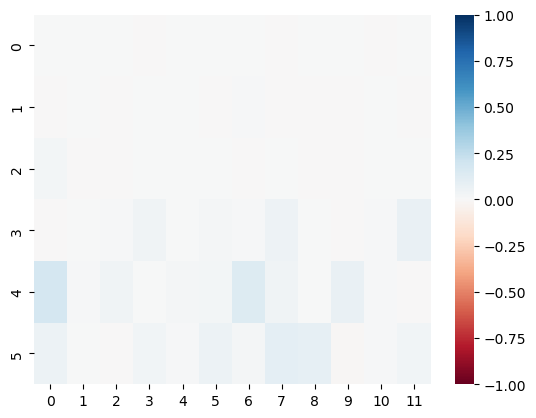

In [89]:
sns.heatmap(
    np.mean(patching_results_normalised[(cluster_labels == 1) & (score_difference > 2)], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

<Axes: >

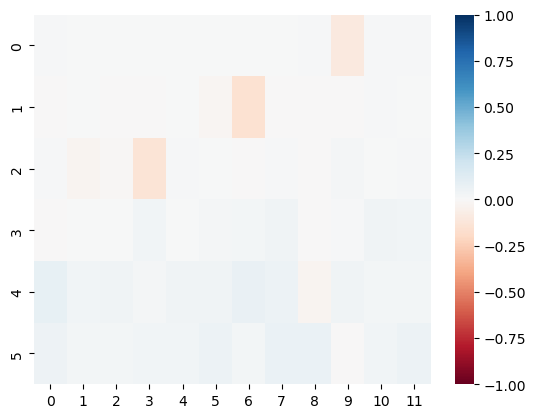

In [94]:
sns.heatmap(
    np.mean(patching_results_normalised[cluster_labels == 0], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

/scratch_local/esx208-1079142/ir_mech_interp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch_local/esx208-1079142/ir_mech_interp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


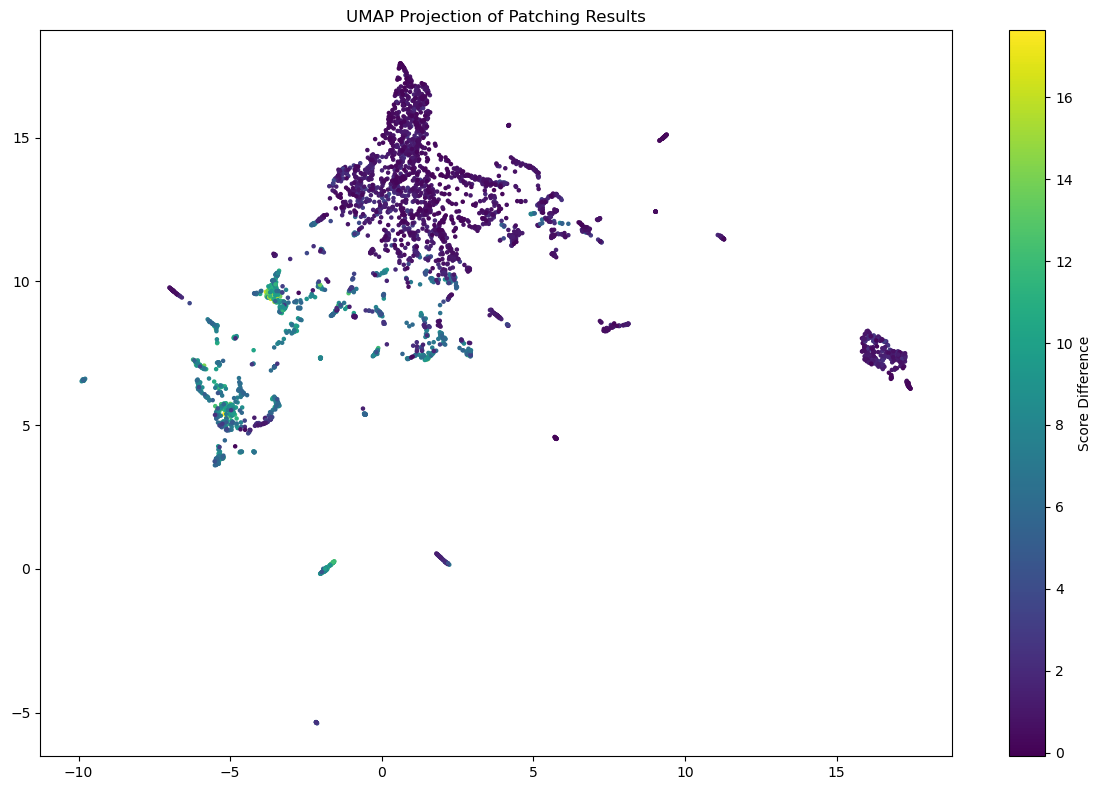

In [127]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embeddings = reducer.fit_transform(patching_results_normalised_vectors)

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=score_difference, cmap='viridis', s=5)
plt.title('UMAP Projection of Patching Results')
plt.colorbar(label='Score Difference')
plt.tight_layout()
plt.show()

In [146]:
np.unique(cluster_labels_umap)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23])

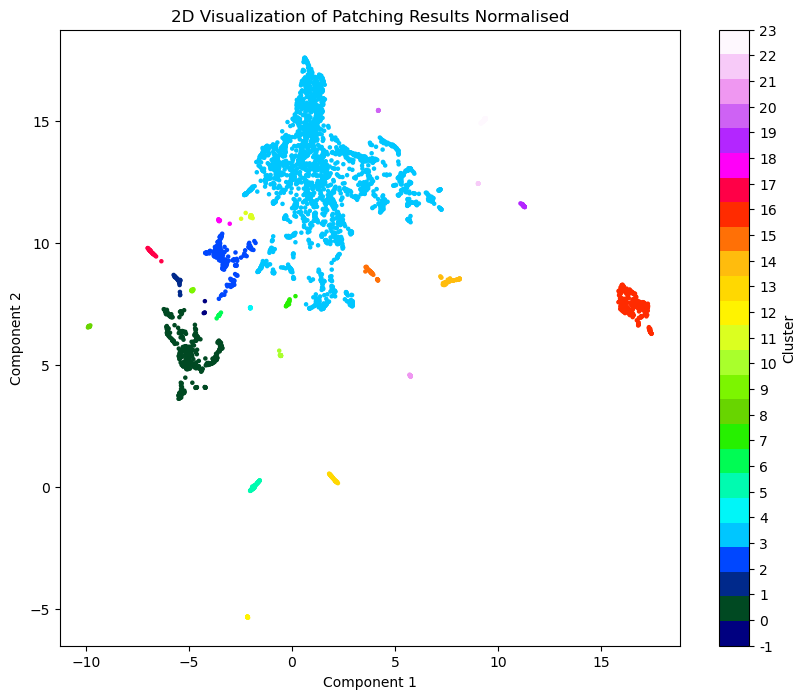

In [147]:
eps=0.5
dbscan_umap = DBSCAN(eps=eps, min_samples=5)
cluster_labels_umap = dbscan_umap.fit_predict(umap_embeddings)

unique_clusters = np.unique(cluster_labels_umap)
n_clusters = len(unique_clusters)

colors = plt.cm.gist_ncar(np.linspace(0, 1, n_clusters))
discrete_cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c = cluster_labels_umap, cmap=discrete_cmap, s=5)

cbar = plt.colorbar(ticks=range(-1, n_clusters-1))
cbar.set_label('Cluster')
cbar.set_ticklabels(range(-1, n_clusters-1))

plt.title('2D Visualization of Patching Results Normalised')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

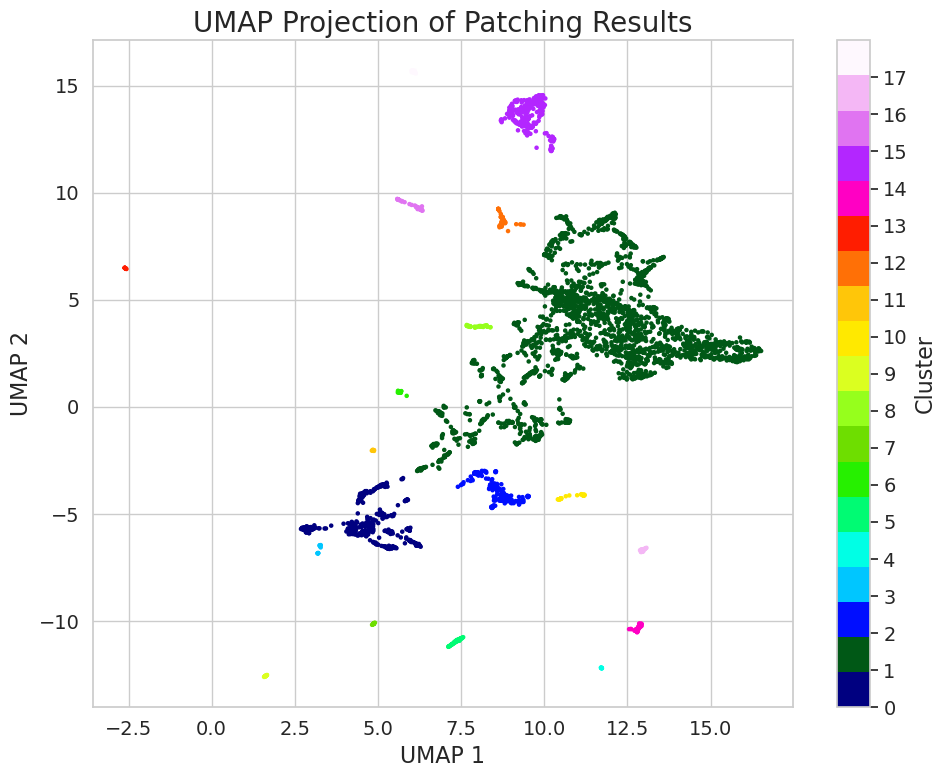

In [41]:
eps=0.5
dbscan_umap = DBSCAN(eps=eps, min_samples=5)
cluster_labels_umap = dbscan_umap.fit_predict(umap_embeddings_square)

unique_clusters = np.unique(cluster_labels_umap)
n_clusters = len(unique_clusters)

colors = plt.cm.gist_ncar(np.linspace(0, 1, n_clusters))
discrete_cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings_square[:, 0], umap_embeddings_square[:, 1], c = cluster_labels_umap, cmap=discrete_cmap, s=5)

cbar = plt.colorbar(ticks=range(-1, n_clusters-1))
cbar.set_label('Cluster')
cbar.set_ticklabels(range(-1, n_clusters-1))

plt.title('UMAP Projection of Patching Results')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()

plt.savefig('/mnt/qb/work/eickhoff/esx208/MechIR/notebooks/plots/dual_encoder_attention_head_patching_umap_clusters.png', bbox_inches='tight')

plt.show()

In [18]:
np.unique(cluster_labels_umap, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18]),
 array([   3,  427, 2546,  197,   14,   13,   75,   29,   21,   44,   23,
          36,   18,   63,   18,   57,  288,   62,   37,   29]))

In [20]:
all_data_pd[cluster_labels_umap == -1]

qid                               query    docno  \
77    490595                  rsa definition key  2061702   
160   490595                  rsa definition key  2061706   
1575  104861  cost of interior concrete flooring   314919   

                                                   text  relevance  perturbed  \
77    The higher your credit score, the lower the in...          0       True   
160   How credit scores affect mortgage rates. Borro...          0       True   
1575  Polishing a Concrete Floor. Sleek, shiny, and ...          1       True   

      perturbed_score  rank  original_score  score_delta  \
77           92.19814   237        79.99070    12.207443   
160          89.97485   250        79.13127    10.843582   
1575         94.33966   510        92.79728     1.542381   

                                         perturbed_text injected_term  
77    The higher your credit score, the lower the in...           rsa  
160   How credit scores affect mortgage rates. Borro...           rsa  
1575  Polishing a Concrete Floor. Sleek, shiny, and ...      interior

In [27]:
all_data_pd[cluster_labels_umap == 0]['query'].value_counts()

query
what is mamey                                              111
what is a alm                                               78
what is theraderm used for                                  60
definition of a sigmet                                      51
what is the un fao                                          28
what is chaff and flare                                     20
exons definition biology                                    17
who is rep scalise?                                         13
what is an aml surveillance analyst                         13
difference between a mcdouble and a double cheeseburger     11
define: geon                                                 8
who is aziz hashim                                           8
how to find the midsegment of a trapezoid                    5
rsa definition key                                           1
define etruscans                                             1
what is reba mcentire's net worth                

In [28]:
all_data_pd[cluster_labels_umap == 0]['injected_term'].value_counts()

injected_term
mamey         111
alm            78
theraderm      60
sigmet         51
fao            28
chaff          20
exons          17
scalise        13
aml            13
mcdouble       11
geon            8
hashim          8
midsegment      5
rsa             1
etruscans       1
reba            1
laudable        1
Name: count, dtype: int64

In [22]:
all_data_pd[cluster_labels_umap == 1]

qid                                              query    docno  \
4      121171                                   define etruscans  7409541   
23    1106007                                   define visceral?  2188708   
30    1133167                      how is the weather in jamaica  6999443   
39    1113437             what is physical description of spruce  5955948   
40    1133167                      how is the weather in jamaica  4265711   
...       ...                                                ...      ...   
3995   451602    medicare's definition of mechanical ventilation  6286982   
3996  1136962  why did the ancient egyptians call their land ...   596001   
3997   258062       how long does it take to remove wisdom tooth  4174313   
3998   583468                           what carvedilol used for  7491704   
3999  1129237        hydrogen is a liquid below what temperature   128982   

                                                   text  relevance  perturbed  \
4     Fully accessible PDF installation guide, and a...          0       True   
23    Your dog comes over to console you and being a...          0       True   
30    (Bring a light jacket just in case you travel ...          0       True   
39    PHYSICAL DESCRIPTION: This species is plain, s...          0       True   
40    The climate is temperate marine and generally ...          0       True   
...                                                 ...        ...        ...   
3995  Mechanical ventilation is indicated when the p...          3       True   
3996  The ancient Egyptian name as transliterated fr...          3       True   
3997  The time it takes to remove the tooth will var...          3       True   
3998  what carvedilol is and what it is used for car...          3       True   
3999  Gas. For hydrogen to become a liquid, you need...          3       True   

      perturbed_score  rank  original_score  score_delta  \
4           92.534620   453       76.296555    16.238068   
23          95.224430   162       80.587180    14.637245   
30         107.293550    84       93.220420    14.073128   
39         105.212290     0       91.735306    13.476982   
40         109.297195     5       95.821655    13.475540   
...               ...   ...             ...          ...   
3995       100.882320    43      100.808110     0.074203   
3996       105.909790    10      105.836235     0.073555   
3997       109.916580    36      109.843506     0.073074   
3998       106.245350    47      106.174270     0.071083   
3999       106.671540    20      106.600746     0.070793   

                                         perturbed_text injected_term  
4     Fully accessible PDF installation guide, and a...     etruscans  
23    Your dog comes over to console you and being a...      visceral  
30    (Bring a light jacket just in case you travel ...       jamaica  
39    PHYSICAL DESCRIPTION: This species is plain, s...        spruce  
40    The climate is temperate marine and generally ...       jamaica  
...                                                 ...           ...  
3995  Mechanical ventilation is indicated when the p...   ventilation  
3996  The ancient Egyptian name as transliterated fr...          call  
3997  The time it takes to remove the tooth will var...        wisdom  
3998  what carvedilol is and what it is used for car...    carvedilol  
3999  Gas. For hydrogen to become a liquid, you need...      hydrogen  

[2546 rows x 12 columns]

In [29]:
all_data_pd[cluster_labels_umap == 1]['query'].value_counts()

query
exons definition biology                                                  194
what is a active margin                                                   118
is caffeine an narcotic                                                   113
define etruscans                                                          104
what is durable medical equipment consist of                               95
                                                                         ... 
define: geon                                                                1
difference between a company's strategy and business model is               1
what is theraderm used for                                                  1
what type of conflict does della face in o, henry the gift of the magi      1
is cdg airport in main paris                                                1
Name: count, Length: 97, dtype: int64

In [30]:
all_data_pd[cluster_labels_umap == 1]['injected_term'].value_counts()

injected_term
exons        187
etruscans    104
low           84
caffeine      66
active        63
            ... 
rsa            1
hygienist      1
redgrave       1
blooded        1
show           1
Name: count, Length: 223, dtype: int64

In [31]:
all_data_pd[cluster_labels_umap == 2]

qid                     query    docno  \
5      583468  what carvedilol used for  7790401   
8      583468  what carvedilol used for     9479   
9      583468  what carvedilol used for  7594822   
10     583468  what carvedilol used for  5702335   
13     583468  what carvedilol used for  5603963   
...       ...                       ...      ...   
2038   443396       lps laws definition  3440853   
2422  1037496       who is rep scalise?   458638   
3001   583468  what carvedilol used for  1379833   
3002   583468  what carvedilol used for  3325050   
3012   443396       lps laws definition  6096578   

                                                   text  relevance  perturbed  \
5     Writing things down will make managing your me...          0       True   
8     A drug used to treat heart attacks, heart fail...          0       True   
9     Use this drug for a condition that is listed i...          0       True   
10    Combined alpha and beta-blockers. Combined alp...          0       True   
13    High blood pressure is a common condition, and...          0       True   
...                                                 ...        ...        ...   
2038  The purpose of this brochure is to explain two...          2       True   
2422  Any time the nation is going through an auster...          2       True   
3001  Uses. This medication is a beta-blocker used t...          3       True   
3002  A beta-blocker is often used to treat high blo...          3       True   
3012  If you have attempted suicide in California an...          3       True   

      perturbed_score  rank  original_score  score_delta  \
5          100.040580   223       83.818680    16.221900   
8          102.227590   172       86.521030    15.706566   
9          105.001884    91       89.302000    15.699882   
10         102.062290   174       86.439850    15.622437   
13          97.658100   299       82.191470    15.466629   
...               ...   ...             ...          ...   
2038        94.442500   131       87.527200     6.915298   
2422        98.649170    67       97.429900     1.219269   
3001       101.841675   182       90.156654    11.685020   
3002        99.755440   233       88.489410    11.266029   
3012        88.645170   192       81.502940     7.142235   

                                         perturbed_text injected_term  
5     Writing things down will make managing your me...    carvedilol  
8     A drug used to treat heart attacks, heart fail...    carvedilol  
9     Use this drug for a condition that is listed i...    carvedilol  
10    Combined alpha and beta-blockers. Combined alp...    carvedilol  
13    High blood pressure is a common condition, and...    carvedilol  
...                                                 ...           ...  
2038  The purpose of this brochure is to explain two...           lps  
2422  Any time the nation is going through an auster...           rep  
3001  Uses. This medication is a beta-blocker used t...    carvedilol  
3002  A beta-blocker is often used to treat high blo...    carvedilol  
3012  If you have attempted suicide in California an...           lps  

[197 rows x 12 columns]

In [32]:
all_data_pd[cluster_labels_umap == 2]['query'].value_counts()

query
what carvedilol used for                                   122
lps laws definition                                         23
meaning of shebang                                          15
who is rep scalise?                                          6
how much money do motivational speakers make                 5
difference between rn and bsn                                4
who is robert gray                                           4
difference between a mcdouble and a double cheeseburger      4
how to find the midsegment of a trapezoid                    4
types of dysarthria from cerebral palsy                      4
is cdg airport in main paris                                 3
axon terminals or synaptic knob definition                   2
what is wifi vs bluetooth                                    1
Name: count, dtype: int64

In [33]:
all_data_pd[cluster_labels_umap == 2]['injected_term'].value_counts()

injected_term
carvedilol      122
lps              23
shebang          15
rep               6
motivational      5
bsn               4
gray              4
cheeseburger      4
trapezoid         4
dysarthria        4
cdg               3
axon              2
wifi              1
Name: count, dtype: int64

In [76]:
cluster_id = 2
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 2
##########
query
what carvedilol used for                                   122
lps laws definition                                         23
meaning of shebang                                          15
who is rep scalise?                                          6
how much money do motivational speakers make                 5
difference between rn and bsn                                4
who is robert gray                                           4
difference between a mcdouble and a double cheeseburger      4
how to find the midsegment of a trapezoid                    4
types of dysarthria from cerebral palsy                      4
is cdg airport in main paris                                 3
axon terminals or synaptic knob definition                   2
what is wifi vs bluetooth                                    1
Name: count, dtype: int64
##########
injected_term
carvedilol      122
lps              23
shebang          15
rep               6
motivational      5

In [66]:
cluster_id = 3
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 3
##########
query
what is a nonconformity? earth science        7
what are the social determinants of health    7
Name: count, dtype: int64
##########
injected_term
nonconformity    7
determinants     7
Name: count, dtype: int64


In [65]:
cluster_id = 4
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 4
##########
query
where is the show shameless filmed    13
Name: count, dtype: int64
##########
injected_term
shameless    13
Name: count, dtype: int64


In [62]:
cluster_id = 5
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())


Cluster ID: 5
##########
query
define bmt medical    75
Name: count, dtype: int64
##########
injected_term
bmt    75
Name: count, dtype: int64


In [63]:
cluster_id = 6
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 6
##########
query
is caffeine an narcotic    29
Name: count, dtype: int64
##########
injected_term
caffeine    29
Name: count, dtype: int64


In [64]:
cluster_id = 7
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 7
##########
query
who is aziz hashim                      20
what does it mean if your tsh is low     1
Name: count, dtype: int64
##########
injected_term
hashim    20
tsh        1
Name: count, dtype: int64


In [67]:
cluster_id = 8
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 8
##########
query
does legionella pneumophila cause pneumonia    43
tracheids are part of _____.                    1
Name: count, dtype: int64
##########
injected_term
pneumophila    43
tracheids       1
Name: count, dtype: int64


In [68]:
cluster_id = 9
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 9
##########
query
how old is vanessa redgrave    23
Name: count, dtype: int64
##########
injected_term
redgrave    23
Name: count, dtype: int64


In [69]:
cluster_id = 10
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 10
##########
query
what is the un fao          20
definition of laudable      15
what is a statutory deed     1
Name: count, dtype: int64
##########
injected_term
un           20
laudable     15
statutory     1
Name: count, dtype: int64


In [70]:
cluster_id = 11
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 11
##########
query
example of monotonic function    18
Name: count, dtype: int64
##########
injected_term
monotonic    18
Name: count, dtype: int64


In [71]:
cluster_id = 12
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 12
##########
query
how is the weather in jamaica                   29
where is the show shameless filmed               9
what is the most popular food in switzerland     8
who sings monk theme song                        7
what are best foods to lower cholesterol         5
does mississippi have an income tax              4
what types of food can you cook sous vide        1
Name: count, dtype: int64
##########
injected_term
weather    29
filmed      9
food        9
sings       6
foods       5
tax         2
income      2
song        1
Name: count, dtype: int64


In [72]:
cluster_id = 13
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 13
##########
query
what does it mean if your tsh is low    18
Name: count, dtype: int64
##########
injected_term
tsh    18
Name: count, dtype: int64


In [73]:
cluster_id = 14
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 14
##########
query
why did the us volunterilay enter ww1    54
define: geon                              3
Name: count, dtype: int64
##########
injected_term
ww1     54
geon     3
Name: count, dtype: int64


In [74]:
cluster_id = 14
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts())
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 14
##########
query
why did the us volunterilay enter ww1    54
define: geon                              3
Name: count, dtype: int64
##########
injected_term
ww1     54
geon     3
Name: count, dtype: int64


In [78]:
cluster_id = 15
print('Cluster ID:', cluster_id)
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['query'].value_counts().head(15))
print('#' * 10)
print(all_data_pd[cluster_labels_umap == cluster_id]['injected_term'].value_counts())

Cluster ID: 15
##########
query
define etruscans                                   86
define bmt medical                                 63
what does it mean if your tsh is low               29
definition of a sigmet                             27
lps laws definition                                22
medicare's definition of mechanical ventilation    11
define pareto chart in statistics                   8
exons definition biology                            7
what is chronometer who invented it                 5
rsa definition key                                  5
types of dysarthria from cerebral palsy             5
does legionella pneumophila cause pneumonia         3
define visceral?                                    3
meaning of shebang                                  3
dog day afternoon meaning                           2
Name: count, dtype: int64
##########
injected_term
define         160
definition      73
mean            29
types            6
invented         5
meaning     

In [57]:
all_data_pd[cluster_labels_umap == 5]['injected_term'].value_counts()

injected_term
bmt    75
Name: count, dtype: int64

In [54]:
all_data_pd[cluster_labels_umap == 6]['query'].value_counts()

query
is caffeine an narcotic    29
Name: count, dtype: int64

In [55]:
all_data_pd[cluster_labels_umap == 6]['injected_term'].value_counts()

injected_term
caffeine    29
Name: count, dtype: int64

In [52]:
all_data_pd[cluster_labels_umap == 7]['query'].value_counts()

query
who is aziz hashim                      20
what does it mean if your tsh is low     1
Name: count, dtype: int64

In [53]:
all_data_pd[cluster_labels_umap == 7]['injected_term'].value_counts()

injected_term
hashim    20
tsh        1
Name: count, dtype: int64

In [50]:
all_data_pd[cluster_labels_umap == 8]['query'].value_counts()

query
does legionella pneumophila cause pneumonia    43
tracheids are part of _____.                    1
Name: count, dtype: int64

In [51]:
all_data_pd[cluster_labels_umap == 8]['injected_term'].value_counts()

injected_term
pneumophila    43
tracheids       1
Name: count, dtype: int64

In [48]:
all_data_pd[cluster_labels_umap == 9]['query'].value_counts()

query
how old is vanessa redgrave    23
Name: count, dtype: int64

In [49]:
all_data_pd[cluster_labels_umap == 9]['injected_term'].value_counts()

injected_term
redgrave    23
Name: count, dtype: int64

In [46]:
all_data_pd[cluster_labels_umap == 10]['query'].value_counts()

query
what is the un fao          20
definition of laudable      15
what is a statutory deed     1
Name: count, dtype: int64

In [47]:
all_data_pd[cluster_labels_umap == 10]['injected_term'].value_counts()

injected_term
un           20
laudable     15
statutory     1
Name: count, dtype: int64

In [45]:
all_data_pd[cluster_labels_umap == 11]['query'].value_counts()

query
example of monotonic function    18
Name: count, dtype: int64

In [44]:
all_data_pd[cluster_labels_umap == 11]['injected_term'].value_counts()

injected_term
monotonic    18
Name: count, dtype: int64

In [41]:
all_data_pd[cluster_labels_umap == 12]['query'].value_counts()

query
how is the weather in jamaica                   29
where is the show shameless filmed               9
what is the most popular food in switzerland     8
who sings monk theme song                        7
what are best foods to lower cholesterol         5
does mississippi have an income tax              4
what types of food can you cook sous vide        1
Name: count, dtype: int64

In [43]:
all_data_pd[cluster_labels_umap == 12]['injected_term'].value_counts()

injected_term
weather    29
filmed      9
food        9
sings       6
foods       5
tax         2
income      2
song        1
Name: count, dtype: int64

In [39]:
all_data_pd[cluster_labels_umap == 13]['query'].value_counts()

query
what does it mean if your tsh is low    18
Name: count, dtype: int64

In [40]:
all_data_pd[cluster_labels_umap == 13]['injected_term'].value_counts()

injected_term
tsh    18
Name: count, dtype: int64

In [35]:
all_data_pd[cluster_labels_umap == 14]['query'].value_counts()

query
why did the us volunterilay enter ww1    54
define: geon                              3
Name: count, dtype: int64

In [36]:
all_data_pd[cluster_labels_umap == 14]['injected_term'].value_counts()

injected_term
ww1     54
geon     3
Name: count, dtype: int64

In [37]:
all_data_pd[cluster_labels_umap == 15]['query'].value_counts()

query
define etruscans                                     86
define bmt medical                                   63
what does it mean if your tsh is low                 29
definition of a sigmet                               27
lps laws definition                                  22
medicare's definition of mechanical ventilation      11
define pareto chart in statistics                     8
exons definition biology                              7
what is chronometer who invented it                   5
rsa definition key                                    5
types of dysarthria from cerebral palsy               5
does legionella pneumophila cause pneumonia           3
define visceral?                                      3
meaning of shebang                                    3
dog day afternoon meaning                             2
what is physical description of spruce                1
who formed the commonwealth of independent states     1
how long is life cycle of flea            

In [38]:
all_data_pd[cluster_labels_umap == 15]['injected_term'].value_counts()

injected_term
define         160
definition      73
mean            29
types            6
invented         5
meaning          5
cause            4
formed           1
description      1
long             1
founded          1
difference       1
who              1
Name: count, dtype: int64

In [24]:
all_data_pd[cluster_labels_umap == 15].injected_term.value_counts()

injected_term
define         160
definition      73
mean            29
types            6
invented         5
meaning          5
cause            4
formed           1
description      1
long             1
founded          1
difference       1
who              1
Name: count, dtype: int64

<Axes: >

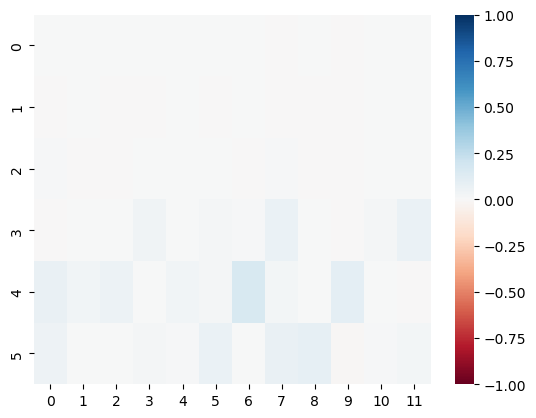

In [149]:
sns.heatmap(
    np.mean(patching_results_normalised[cluster_labels == 0], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

In [150]:
all_data_pd[cluster_labels == 1]

qid                              query    docno  \
4     121171                   define etruscans  7409541   
74    121171                   define etruscans  2367589   
77    490595                 rsa definition key  2061702   
122   121171                   define etruscans  6858629   
139   121171                   define etruscans  1160097   
155   121171                   define etruscans  1181917   
160   490595                 rsa definition key  2061706   
198   121171                   define etruscans  6462279   
206   121171                   define etruscans  4785931   
249   121171                   define etruscans  1207573   
278   121171                   define etruscans  1105284   
285   121171                   define etruscans  7274060   
334   121171                   define etruscans  1075868   
338   121171                   define etruscans  8019081   
357   121171                   define etruscans  1236382   
380   121171                   define etruscans  1260874   
422   490595                 rsa definition key  3503015   
432   121171                   define etruscans  3573421   
442   121171                   define etruscans  1178694   
456   121171                   define etruscans  1114530   
466   121171                   define etruscans  6096116   
478  1106979  define pareto chart in statistics  1140656   
507   121171                   define etruscans  2954055   
516   121171                   define etruscans  6289802   
578  1106979  define pareto chart in statistics  3890355   
642   121171                   define etruscans  1100675   
724   121171                   define etruscans   165363   
728   121171                   define etruscans  5679596   
781   121171                   define etruscans  4788891   
795   121171                   define etruscans  1249459   
808   121171                   define etruscans  4983778   
820   121171                   define etruscans   278324   
940   121171                   define etruscans  1683909   

                                                  text  relevance  perturbed  \
4    Fully accessible PDF installation guide, and a...          0       True   
74   Some of the earliest directions we have are fr...          0       True   
77   The higher your credit score, the lower the in...          0       True   
122  noun, (usually used with a singular verb) 1. a...          0       True   
139  Irla Level. Free PDF eBook Download: Irla Leve...          0       True   
155  ASSASSINATION THEATER. WHAT:ASSASSINATION THEA...          0       True   
160  How credit scores affect mortgage rates. Borro...          0       True   
198  Let's review. The Indus Valley civilization, o...          0       True   
206  The people of Western Europe who lived during ...          0       True   
249  Bonding Jumper, System. The connection between...          0       True   
278  judicial admission. Thesaurus. Definitions of ...          0       True   
285  Definition of antique. 1 : existing since or b...          0       True   
334  Louisiana Creole (Kreyol Kréyol La) lwizyan lw...          0       True   
338  Elements of Greek mythology have appeared many...          0       True   
357  Conversion of dental porcelain (frit) to a gla...          0       True   
380  preventive strike. Thesaurus. Definitions of p...          0       True   
422  A cryptographic algorithm (also called a encry...          0       True   
432  The first well-known literate civilization in ...          0       True   
442  A hawker centre in Lavender, Singapore. A hawk...          0       True   
456  Beginning in the eighth century B.C., Ancient ...          0       True   
466  Carthage was a major power in the Mediterranea...          0       True   
478  To introduce the perpendicular unit vectors. †...          0       True   
507  The civilization of ancient Greece lasted from...          0       True   
516  A fasces image, with the axe in the middle 

<Axes: >

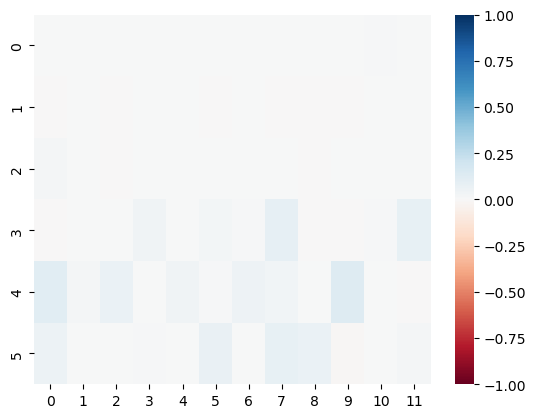

In [151]:
sns.heatmap(
    np.mean(patching_results_normalised[cluster_labels == 1], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)

In [153]:
all_data_pd[cluster_labels == 2]['injected_term'].value_counts()

injected_term
carvedilol      122
lps              23
visceral         18
shebang          15
trapezoid         6
motivational      5
cheeseburger      5
bsn               4
dysarthria        4
gray              4
granulation       3
cdg               3
pelvic            3
synaptic          2
axon              2
land              2
interior          2
carnitine         1
wifi              1
Name: count, dtype: int64

<Axes: >

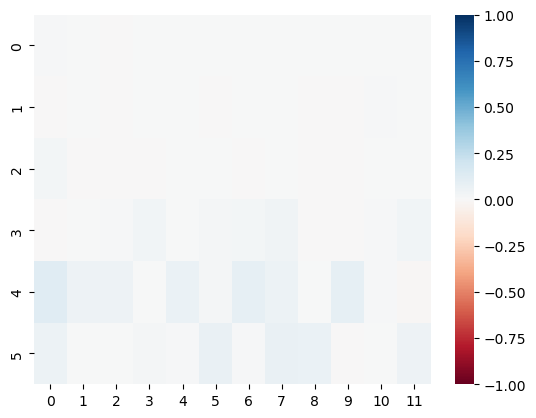

In [154]:
sns.heatmap(
    np.mean(patching_results_normalised[cluster_labels == 2], axis=0),
    vmin=-1,
    vmax=1,
    cmap='RdBu',
)